In [176]:
import numpy as np
import regex as re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import pickle
from collections import defaultdict


import matplotlib.patches as patches
#from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

import seaborn as sns
from matplotlib.lines import Line2D
import networkx as nx
import community as community_louvain
import datetime

from PIL import Image

In [2]:
#Query for type of data "Afstemning". The query returns (per default) the first 100 matches, as well as a  the "Sagstrin" and "Sag" and filter for "vedtaget" (true)
#old query
#url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=vedtaget eq true&$inlinecount=allpages'


# Overview of contents
This explainer notebook contains the majority of the code used for the analysis, which makes it quite expansive.
The material is presented in the following order:
* 1) Data collection and cleaning
* 2) Basic descriptive statistics
* 3) Creation of network graphs
* 4) Clustering algorithm
* 5) Temporal analysis of party collaboration
* 6) TF-IDF

The reader should feel free to skip sections that are deemed less relevant.



# 1) Data collection and cleaning
### Sitching together multiple queries from oda.ft
The data we are looking for is accesable via oda.ft, but can not be reached via a single query. The data is organized after a data structure described here, https://oda.ft.dk/Home/OdaModel , and in order to obtain information about what the specific politicans voted for, in relation to a specific law proposal, we need to combine and match the following queries:
- Query 1: Obtain all votings (afstemninger):
    - Get all law votings that has been passed, information about the laws, including the unique ID of each individual law
- Query 2: Obtain all individual vote IDs, for a given voting
    - For a given voting, get a list of the unique numerric actor IDs that has voted for a specific law (which is tied to a politican), as well as whether the vote was yes, no or absent
- Query 3: Obtain the relation between actor IDs and politicans
    - Get the map between numeric actor ID and entity, and match this to the voting IDs of query 2

### Query 1: Obtain all votings (afstemning) 
The query returns (per default) a json with 3 keys: 'metadata', 'value' and 'nextlink'
- the 'value' key contains a list of up 100 votings, each voting is a dict with 11 keys
- the 'nextlink' key contains a link to the next 100 votings, as well as the link for the next 100 and so forth

Filtering is done by expanding the "Sagstrin" and "Sag" keys of each voting and filtering for 3 things:
- "vedtaget" = true, the voting ended in approval
-  "sagstrin id = 17" = "3rd reading" meaning that this is the final processing of the law, if passed here, the law is implemented
-  "sag id = 3" = lovforslag, meaning that this is a law proposal (could be a voting for something else, like a budget)

In [7]:
url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=typeid eq 1 and vedtaget eq true and Sagstrin/typeid eq 17 and Sagstrin/Sag/typeid eq 3&$inlinecount=allpages'

In [11]:
#This function takes dict, extracts the next link, gets the new dict and appends it to the old dict


def get_all_pages(url):

    r = requests.get(url)

    sager = r.json()
    prev = r.json()

    while 'odata.nextLink' in prev:

        r = requests.get(prev['odata.nextLink'])
        sager['value'] += r.json()['value']
        prev = r.json()

    return sager

In [12]:
sager = get_all_pages(url_sager)
clean_sager = [sag for sag in sager['value']]

In [13]:
print(f'Hence we have a total of {len(clean_sager)} sager')

Hence we have a total of 3828 sager


In [14]:

#format dict to json
#json_sager = json.dumps([clean_sager[0]])
#parsed = json.loads(json_sager)
#print(json.dumps(parsed, indent=4))

Each voting is 3 layered nested dict with the following structure:
- Top layer, voting: Information about the voting, unique ID of the voting, whether it was approved, date of approval etc. as seen below

In [15]:
clean_sager[0].keys()

dict_keys(['Sagstrin', 'id', 'nummer', 'konklusion', 'vedtaget', 'kommentar', 'mødeid', 'typeid', 'sagstrinid', 'opdateringsdato'])

- Mid layer, "sagstrin" / "case stage": Nested dict within the voting, about the specific case process, what type of process is this (voting), what date, where was it held etc.,

In [16]:
clean_sager[0]['Sagstrin'].keys()

dict_keys(['Sag', 'id', 'titel', 'dato', 'sagid', 'typeid', 'folketingstidendeurl', 'folketingstidende', 'folketingstidendesidenummer', 'statusid', 'opdateringsdato'])

- Bottom layer, 'sag' / 'case': Nested dict within 'sagstrin, information about the specific case, in this case a law, what the law is about, the law number, category and a range of other values relating to the law itself. 

In [17]:
clean_sager[0]['Sagstrin']['Sag'].keys()

dict_keys(['id', 'typeid', 'kategoriid', 'statusid', 'titel', 'titelkort', 'offentlighedskode', 'nummer', 'nummerprefix', 'nummernumerisk', 'nummerpostfix', 'resume', 'afstemningskonklusion', 'periodeid', 'afgørelsesresultatkode', 'baggrundsmateriale', 'opdateringsdato', 'statsbudgetsag', 'begrundelse', 'paragrafnummer', 'paragraf', 'afgørelsesdato', 'afgørelse', 'rådsmødedato', 'lovnummer', 'lovnummerdato', 'retsinformationsurl', 'fremsatundersagid', 'deltundersagid'])

#### Save relevant variables as dataframe
We save all the relevant fields from this query into our law dataframe

In [18]:
import pandas as pd
import numpy as np

def law_info(data):
    df = pd.DataFrame()

    df['afstemnings_id'] = [x['id'] for x in data]
    #df['sagstrin_id'] = [x['sagstrinid'] for x in data]
    #df['vedtaget'] = [x['vedtaget'] for x in data]
    #df['dato_afst_opd'] = [x['opdateringsdato'] for x in data]
    df['dato_sagstrin'] = [x['Sagstrin']['dato'] for x in data]
    #df['dato_sag_opd'] = [x['Sagstrin']['Sag']['opdateringsdato'] for x in data]
    df['sag_id'] = [x['Sagstrin']['Sag']['id'] for x in data]
    df['titel']= [x['Sagstrin']['Sag']['titel'] for x in data]
    df['titel_kort'] = [x['Sagstrin']['Sag']['titelkort'] for x in data]
    df['lovnummer_num'] = [x['Sagstrin']['Sag']['nummernumerisk'] for x in data]
    #df['lovnummer'] = [x['Sagstrin']['Sag']['nummer'] for x in data]
    df['resume']= [x['Sagstrin']['Sag']['resume'] for x in data]
    df['periode_id']= [x['Sagstrin']['Sag']['periodeid'] for x in data]

    return df
        
law_info = law_info(clean_sager)
law_info.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  
0  Loven ændrer virksomhedsskatteordningens regle...          32  
1  Med loven etableres en midlertidig ordning, så...          31  
2  Loven ændrer virksomhedsskatteordningens regle...          32  
3  Med loven åbnes der mulighed for, at Region No...          32  
4  Loven indeholder bemyndigelse til, at transpor...          32

### Query 2: Obtain individual IDs in relation to votings (aktør ID @ afstemning) 

In [19]:
#This function takes an id for a vote and collects all the votes for that vote


def get_all_votes(id):
    url = f'https://oda.ft.dk/api/Afstemning({id})/Stemme?$inlinecount=allpages'
    r = requests.get(url)
    votes = r.json()
    prev = r.json()
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        votes['value'] += r.json()['value']
        prev = r.json()
        
    return votes


votes_test = get_all_votes(clean_sager[0]['id'])

For each voting ID (a law) the function returns a list of dicts, where each dict is equavalent to a vote for that speifici law, and contains the ID of the voter (aktørid) and what was voted ("afstemningsid), along with a few other variables.

In [20]:
votes_test['value'][0]

{'id': 180,
 'typeid': 1,
 'afstemningid': 2,
 'aktørid': 158,
 'opdateringsdato': '2014-09-09T09:25:05.717'}

### Save relevant variables as a DF
Using the function we just wrote, and applying it to the list of all laws, we create a DF that contains a row for each vote defined by the unique ID of that voting, along with a dict containing all the votes for that law processing.

In [21]:
#THIS FUNCTION TAKES 10+ MINUTES TO RUN - INSTEAD; SCROLL DOWN TO NEXT CELL AND LOAD DATAFRAME FROM PICKLE

#This function takes in a df of each vote and makes a dataframe of all the votes for each vote
def votes_df(voting_df):
    df = pd.DataFrame()

    #typeid: 1=ja, 2=nej, 3=blank, 4=fraværende

    df["afstemnings_id"] = voting_df["afstemnings_id"].values
    df["votes_combined_info"] = [get_all_votes(x)['value'] for x in voting_df['afstemnings_id']] #creates a dict
    

    return df

#vote_df = votes_df(law_info)

In [64]:
#save df as pickle
#vote_df.to_pickle('vote_df.pkl')

In [22]:
#load vote_df from pickle
vote_df = pd.read_pickle('vote_df.pkl')

In [23]:
vote_df.head()

afstemnings_id                                votes_combined_info
0               2  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...
1               4  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...
2               5  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...
3               9  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...
4              10  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...

### Query 3: Obtain a map between the numerical actor id (aktørid) of all politicians that has voted, and onto the actual name of the politician and the party of which they belong

#### Create a function that returns the name and party of a politican, given the unique actor-id and relevant period ids

In [24]:
import requests

def get_politician_info(id: int, period_id_list: list):
    
    politician = {}
    politician['party'] = {}

    #First, Look up name of politician given the actor id, and add the name to the politician dict
    name_url = f'https://oda.ft.dk/api/Akt%C3%B8r({id})'
    try:
        response = requests.get(name_url)
        data_json = response.json()
        try:
            politician['navn'] = data_json['fornavn'] + ' ' + data_json['efternavn']
        except:
            politician['navn'] = 'unknown'
    except:
        print('WARNING: name URL not found for id:', id)
        print(name_url)
        politician['navn'] = 'invalid_url'
        
    #Next, look up the party of a given actor, in a given period, add the party of each period as a dict, to the politician dict
    for periode_id in period_id_list:
        party_url = f'https://oda.ft.dk/api/AktørAktør?$expand=FraAktør,TilAktør/Aktørtype&$filter=FraAktør/id eq {id} and TilAktør/Aktørtype/type eq \'Folketingsgruppe\' and TilAktør/periodeid eq {periode_id}&$inlinecount=allpages'

        try:
            response = requests.get(party_url)
            data_json = response.json()
                
            try:
                party = data_json['value'][0]['TilAktør']['navn']
                politician['party'][periode_id] = party
            except:
                print('party not found for id:', id, 'in period:', periode_id)
                politician['party'][periode_id] = 'unknown'
                print(party_url)
        except:
                print('WARNING: party URL not found for id:', id, 'in period:', periode_id)
                politician['party'][periode_id] = 'invalid_url'
                print(party_url)
    
            
    return politician


In [25]:
#To look up the info of a politician we need a collection of all the politician ids as wel as the period ids of which each politician was part of the parlaiment

def get_all_politician_periods(law_df):
    politician_periode_id_dict = dict()
    for index, row in law_df.iterrows():
        for vote in row['votes_combined_info']:
            if vote['aktørid'] in politician_periode_id_dict:
                if row['periode_id'] not in politician_periode_id_dict[vote['aktørid']]:
                    politician_periode_id_dict[vote['aktørid']].append(row['periode_id'])
            else:
                politician_periode_id_dict[vote['aktørid']] = [row['periode_id']]
    return politician_periode_id_dict
        
#politician_periode_id_dict = get_all_politician_periods(law_info)

In [26]:
def get_all_politician_info(politician_id_period: dict):
    politician_df = pd.DataFrame(columns=['politician_name', 'party', 'politician_id'])
    for id, period_id_list in politician_id_period.items():
        politician = get_politician_info(id, period_id_list)
        politician_clean_df = politician_df.append({'politician_name': politician['navn'], 'party': politician['party'], 'politician_id': id}, ignore_index=True)
    return politician_df

In [18]:
#Takes 4-6 minutes to run, instead, load the pickle below at the end of the next cleaning section

#politician_df = get_all_politician_info(politician_periode_id_dict)

In [27]:
#save df as pickle
#politician_df.to_pickle('politician_df.pkl')
politician_df = pd.read_pickle('politician_df.pkl')

#### Cleaning politicians: Absent parties
Some politicians does not have any parties matching a period even though they voted in that same period.
As this only accounts for 6 politicians, we manually adjust the parties in the periods.

In [28]:
# Manually adjust politicians parties if they have voted in a specific period
politician_clean_df = politician_df.copy()

By looking up the politicians in the system, we found that all of the politicians that were missing information about their party at a certain period was all from Socialdemokratiet.

In [29]:
for politician in politician_clean_df.itertuples():
    # If politician is Peter Christian Christensen, Jytte Andersen, Carsten Hansen, Torben Hansen, Mogens Jensen or Frode Sørensen
    if politician.politician_id in (1414, 8319, 5593, 7633, 5905, 3042):
        # Change party to Socialdemokratiet
        for key in politician.party.keys():
            politician.party[key] = 'Socialdemokratiet'
        print(politician)

Pandas(Index=300, politician_name='Peter Christian Christensen', party={27: 'Socialdemokratiet'}, politician_id=1414)
Pandas(Index=396, politician_name='Jytte  Andersen', party={24: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet', 20: 'Socialdemokratiet'}, politician_id=8319)
Pandas(Index=410, politician_name='unknown', party={24: 'Socialdemokratiet', 25: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet', 20: 'Socialdemokratiet'}, politician_id=5593)
Pandas(Index=412, politician_name='Torben  Hansen', party={24: 'Socialdemokratiet', 25: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet', 20: 'Socialdemokratiet'}, politician_id=7633)
Pandas(Index=418, politician_name='Mogens Jensen,  Brøndby', party={24: 'Socialdemokratiet', 25: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet'}, politician_id=5905)
Pandas(In

One of the politicians are also missing their name. We will manually add this as we can find it in the data.

In [30]:
for politician in politician_clean_df.itertuples():
    # If politician is Carsten Hansen
    if politician.politician_id == 5593:
        # Change name to Carsten Hansen
        politician_clean_df['politician_name'] = politician_clean_df['politician_name'].replace('unknown', 'Carsten Hansen')
        print(politician)

Pandas(Index=410, politician_name='unknown', party={24: 'Socialdemokratiet', 25: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet', 20: 'Socialdemokratiet'}, politician_id=5593)


In [31]:
print(politician_clean_df[politician_clean_df['politician_name'] == 'Carsten Hansen'])

    politician_name                                              party  \
115  Carsten Hansen  {32: 'Socialdemokratiet', 31: 'Socialdemokrati...   
410  Carsten Hansen  {24: 'Socialdemokratiet', 25: 'Socialdemokrati...   

    politician_id  
115            92  
410          5593  


In [32]:
print(politician_clean_df[politician_clean_df['politician_name'] == 'Carsten Hansen'].party.values[0])
print(politician_clean_df[politician_clean_df['politician_name'] == 'Carsten Hansen'].party.values[1])

{32: 'Socialdemokratiet', 31: 'Socialdemokratiet', 30: 'Socialdemokratiet', 28: 'Socialdemokratiet', 35: 'Socialdemokratiet', 27: 'Socialdemokratiet', 26: 'Socialdemokratiet', 25: 'Socialdemokratiet', 146: 'Socialdemokratiet'}
{24: 'Socialdemokratiet', 25: 'Socialdemokratiet', 23: 'Socialdemokratiet', 22: 'Socialdemokratiet', 21: 'Socialdemokratiet', 20: 'Socialdemokratiet'}


There seem to be two politician ids for Carsten Hansen, however the period ids doesn't seem to overlap, so it seems that he has voted under two different ids during his time in Folketinget.

In [33]:
politician_clean_df.head()

politician_name                                              party  \
0   Eigil Andersen  {32: 'Socialistisk Folkeparti', 31: 'Socialist...   
1     Kim Andersen  {32: 'Venstre, Danmarks Liberale Parti', 31: '...   
2       Tom Behnke  {32: 'Det Konservative Folkeparti', 31: 'Det K...   
3   Liselott Blixt  {32: 'Dansk Folkeparti', 31: 'Dansk Folkeparti...   
4  Erling Bonnesen  {32: 'Venstre, Danmarks Liberale Parti', 31: '...   

  politician_id  
0           158  
1           126  
2            71  
3            50  
4            49

In [34]:
#print the unique parties in the values of the dicts in the party column
unique_parties = set()
for party_dict in politician_clean_df['party']:
    for party in party_dict.values():
        unique_parties.add(party)
print(unique_parties)

{'Nunatta Qitornai', 'Tjóðveldisflokkurin', 'Tjóðveldi', 'Dansk Folkeparti', 'Javnaðarflokkurin', 'Kristendemokraterne', 'Nye Borgerlige', 'Ny Alliance', 'Venstre, Danmarks Liberale Parti', 'Liberal Alliance', 'Fólkaflokkurin', 'Socialistisk Folkeparti', 'Socialdemokratiet', 'Radikale Venstre', 'Sambandsflokkurin', 'Enhedslisten', 'Det Konservative Folkeparti', 'Inuit Ataqatigiit', 'Alternativet', 'Uden for folketingsgrupperne', 'Siumut'}


In [35]:
#Clean the parties that are called "Uden for Folketingsgrupperne- #name of politician" to just be "Uden for folketingsgrupperne"
#And that we have both a party called "Det Radikale Venstre" and another "Radikale Venstre"

for party_dict in politician_clean_df['party']:
    for key, party in party_dict.items():
        #use regex to search for strings that contain the sentence "Uden for folketingsgrupperne"
        if re.search(r'Uden for folketingsgrupperne', party):
            party_dict[key] = 'Uden for folketingsgrupperne'
        if re.search(r'Radikale Venstre', party):
            party_dict[key] = 'Radikale Venstre'



### LOAD THIS PICKLE

In [36]:
#write the politician_df to a pickle
#politician_clean_df.to_pickle('politician_df_clean.pkl')
politician_clean_df = pd.read_pickle('politician_df_clean.pkl')

In [37]:
#print the unique parties in the values of the dicts in the party column
unique_parties = set()
for party_dict in politician_clean_df['party']:
    for party in party_dict.values():
        unique_parties.add(party)
print(unique_parties)

{'Nunatta Qitornai', 'Tjóðveldisflokkurin', 'Tjóðveldi', 'Dansk Folkeparti', 'Javnaðarflokkurin', 'Kristendemokraterne', 'Nye Borgerlige', 'Ny Alliance', 'Venstre, Danmarks Liberale Parti', 'Liberal Alliance', 'Fólkaflokkurin', 'Socialistisk Folkeparti', 'Socialdemokratiet', 'Radikale Venstre', 'Sambandsflokkurin', 'Enhedslisten', 'Det Konservative Folkeparti', 'Inuit Ataqatigiit', 'Alternativet', 'Uden for folketingsgrupperne', 'Siumut'}


# 2) Summary and further cleaning
#### We now have the following 3 dataframes:

In [38]:
#A dataframe containing every single passed law and its information
law_info.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  
0  Loven ændrer virksomhedsskatteordningens regle...          32  
1  Med loven etableres en midlertidig ordning, så...          31  
2  Loven ændrer virksomhedsskatteordningens regle...          32  
3  Med loven åbnes der mulighed for, at Region No...          32  
4  Loven indeholder bemyndigelse til, at transpor...          32

In [39]:
#A dataframe containing a dict with the unique votes for each law, related to the numerical actor IDs of the politicians that voted
vote_df.head()

afstemnings_id                                votes_combined_info
0               2  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...
1               4  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...
2               5  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...
3               9  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...
4              10  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...

In [40]:
#A dataframe containing the unique actor IDs of each politican, linked to their their name and party (except for the politicians where we could not find the party)
politician_clean_df.head()

politician_name                                              party  \
0   Eigil Andersen  {32: 'Socialistisk Folkeparti', 31: 'Socialist...   
1     Kim Andersen  {32: 'Venstre, Danmarks Liberale Parti', 31: '...   
2       Tom Behnke  {32: 'Det Konservative Folkeparti', 31: 'Det K...   
3   Liselott Blixt  {32: 'Dansk Folkeparti', 31: 'Dansk Folkeparti...   
4  Erling Bonnesen  {32: 'Venstre, Danmarks Liberale Parti', 31: '...   

  politician_id  
0           158  
1           126  
2            71  
3            50  
4            49

In [41]:
#We decide to add the votes_combined_info column to the law_info dataframe
law_info['votes_combined_info'] = vote_df['votes_combined_info']

#### Cleaning 1: Some laws lack matched individual votes

By plotting a histogram of the different vote categories, we noticed a few problems...

First, by plotting yes votes for passed laws, we would expect there always to be more than 0 vores. However, a number of passed laws seem to have 0 yes votes associated, this can not be true. By looking further into the data, it appears that a number of laws - for unknown reasons - simply does not contain the data of what the individual actors voted. We will remove these laws.


In [42]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in vote_df['votes_combined_info']]

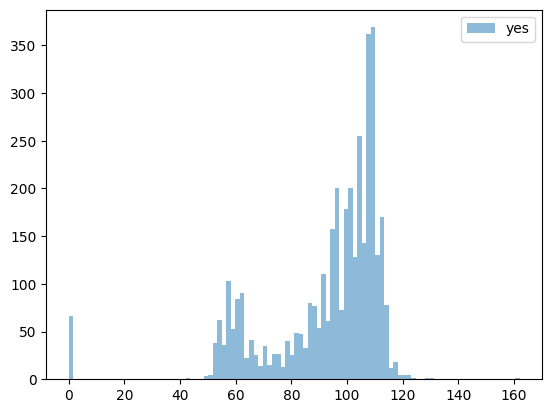

In [43]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
plt.hist(yes_votes, bins=100, alpha=0.5, label='yes')
plt.legend(loc='upper right')
plt.show()

In [44]:
#count the total number of rows of the law_info dataframe where the votes_combined info column contains an empty list
print(f"Number of laws with no votes: {len(law_info[law_info['votes_combined_info'].map(len) == 0])}")

Number of laws with no votes: 66


In [45]:
#Remove the rows where the votes_combined_info column contains an empty list, and create a new copy of the dataframes
df_law_clean = law_info[law_info['votes_combined_info'].map(len) != 0].copy()
df_votes_clean = vote_df[vote_df['votes_combined_info'].map(len) != 0].copy()

#### Cleaning 2: Absent votes does not mean no
As the plot below shows, there´s generally between 90-115 yes votes, whereas the remainder of 60-80 are absent.

It turns out, there is an agreement between parties, that if it is known that one coalliation has enough votes to pass a law, the parties across the coalliations agree as to only send a representative quantity of politicians to do the actual voting. The remainder of politicians refrain from voting thereby getting the "absent" voting label. This does however NOT mean that the absent politician disagreed with a given law, rather it typically means that a given politican actually agree with the general line of voting of his/her party. 



In [46]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 2 (no)
no_votes = [len([x for x in y if x['typeid'] == 2]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 3 (absent)
absent_votes = [len([x for x in y if x['typeid'] == 3]) for y in df_law_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 4 (blank)
blank_votes = [len([x for x in y if x['typeid'] == 4]) for y in df_law_clean['votes_combined_info']]

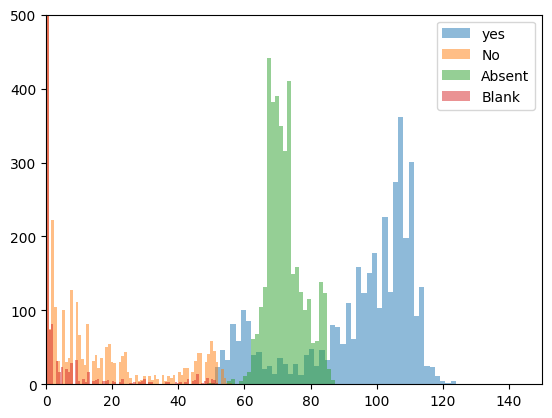

In [47]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
#Only plot the y axis up to 500 as there are more than 3000 instances of no and blank votes
plt.hist(yes_votes, bins=75, alpha=0.5, label='yes')
plt.hist(no_votes, bins=75, alpha=0.5, label='No')
plt.hist(absent_votes, bins=75, alpha=0.5, label='Absent')
plt.hist(blank_votes, bins=75, alpha=0.5, label='Blank')
plt.ylim(0,500)
plt.xlim(0,150)
plt.legend(loc='upper right')
plt.show()


To solve the problem of absent votes, we will make the assumption, that for a given voting, if a politican has an "absent" vote, we will instead assign the most common type of vote from the party of this politician.

For any given voting, if the entire party voted absent, the votes are retained as absent.

The problem is further complexed by the challenge that some politicians change political party, hence we also need to consider a time-dimension when we do the mapping.

In [48]:
#copy the votes_df dataframe to a new dataframe where we will combine the politician data, and infer the type of vote for all the absent votes
df_votes_politicians_clean = df_votes_clean.copy()

In [49]:
df_votes_politicians_clean['periode_id'] = df_law_clean['periode_id']
df_votes_politicians_clean.head()

afstemnings_id                                votes_combined_info  \
0               2  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...   
1               4  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...   
2               5  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...   
3               9  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...   
4              10  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...   

   periode_id  
0          32  
1          31  
2          32  
3          32  
4          32

In [50]:
#For each index in the vote_df votes_combined_info column, add a new key called "party" and assign the value of the party by matching the id with the politican_df dataframe

for index, row in df_votes_politicians_clean.iterrows():
    for i in range(len(row['votes_combined_info'])):
        matched_politician = politician_clean_df[politician_clean_df['politician_id'] == row['votes_combined_info'][i]['aktørid']]
    
        #row['votes_combined_info'][i]['party'] = matched_politician['party'].values[0]
        #Find the party by looking up in the df_votes_politicians dataframe with the matched actor ID and the period ID
        try:
            party = matched_politician['party'].values[0][row['periode_id']]
        except:
            print(f"Could not match periode ID key {row['periode_id']} for actor ID {row['votes_combined_info'][i]['aktørid']}")	
            print(f"This person: {matched_politician}")
        if party == 'uknown':
            print(f"No party for actor id: {row['votes_combined_info'][i]['aktørid']}")
            print(f"No party for {matched_politician['politician_name'].values[0]}, in period {row['periode_id']}, party: {party}")
        row['votes_combined_info'][i]['party'] = party
        row['votes_combined_info'][i]['name'] = matched_politician['politician_name'].values[0]

In [51]:
#Function that returns the majority typeid for each party for a given law
def get_majority_typeid_for_party(law):
    #Create a dict with the party as key and the typeid as value
    party_typeid_dict = {}
    for vote in law:
        #Do not include absent votes
        if vote['typeid'] != 3:
            #If the party is not already in the dict, add it
            if vote['party'] not in party_typeid_dict:
                party_typeid_dict[vote['party']] = [vote['typeid']]
            #If the party is already in the dict, append the typeid to the list of typeids
            else:
                party_typeid_dict[vote['party']].append(vote['typeid'])
    #Create a dict with the party as key and the majority typeid as value
    party_majority_typeid_dict = {}
    for party in party_typeid_dict:
        #Get the most common typeid for each party
        party_majority_typeid_dict[party] = max(set(party_typeid_dict[party]), key=party_typeid_dict[party].count)
    return party_majority_typeid_dict

#create a new column in the votes_df_combined dataframe called majority_typeid_for_party
df_votes_politicians_clean['majority_party_vote'] = [get_majority_typeid_for_party(law) for law in df_votes_politicians_clean['votes_combined_info']]

In [52]:
#create a new column in the votes_df_combined dataframe called votes_adjusted that is a copy of the votes_combined_info column
#For each row in the votes_df_combined dataframe, check each element in the votes_adjusted info
#if the typeid = 3 (absent), then replace the typeid with the majority typeid for that party

df_votes_politicians_clean['votes_adjusted'] = df_votes_politicians_clean['votes_combined_info'].copy()
for index, row in df_votes_politicians_clean.iterrows():
    for i in range(len(row['votes_adjusted'])):
        if row['votes_adjusted'][i]['typeid'] == 3:
            #if the party is in the dict (in case there are no majority vote other than absent for that party, retain absent vote)
            if row['votes_adjusted'][i]['party'] in row['majority_party_vote'] and row['votes_adjusted'][i]['party'] != 'uknown' and row['votes_adjusted'][i]['party'] != 'Uden for folketingsgrupperne':
                row['votes_adjusted'][i]['typeid'] = row['majority_party_vote'][row['votes_adjusted'][i]['party']]

In [53]:
df_votes_politicians_clean.head()

afstemnings_id                                votes_combined_info  \
0               2  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...   
1               4  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...   
2               5  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...   
3               9  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...   
4              10  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...   

   periode_id                                majority_party_vote  \
0          32  {'Socialistisk Folkeparti': 1, 'Venstre, Danma...   
1          31  {'Socialistisk Folkeparti': 1, 'Socialdemokrat...   
2          32  {'Socialistisk Folkeparti': 1, 'Venstre, Danma...   
3          32  {'Dansk Folkeparti': 4, 'Socialistisk Folkepar...   
4          32  {'Dansk Folkeparti': 1, 'Socialistisk Folkepar...   

                                      votes_adjusted  
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...  
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...  
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...  
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...  
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...

In [57]:
#Save the combined dataframe using pickle
#with open('df_votes_politicians_clean.pickle', 'wb') as f:
#    pickle.dump(df_votes_politicians_clean, f)

#Load d_votes_politicians_clean dataframe using pickle
with open('df_votes_politicians_clean.pickle', 'rb') as f:
    df_votes_politicians_clean = pickle.load(f)

In [58]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 2 (no)
no_votes = [len([x for x in y if x['typeid'] == 2]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 3 (absent)
absent_votes = [len([x for x in y if x['typeid'] == 3]) for y in df_votes_politicians_clean['votes_combined_info']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 4 (blank)
blank_votes = [len([x for x in y if x['typeid'] == 4]) for y in df_votes_politicians_clean['votes_combined_info']]

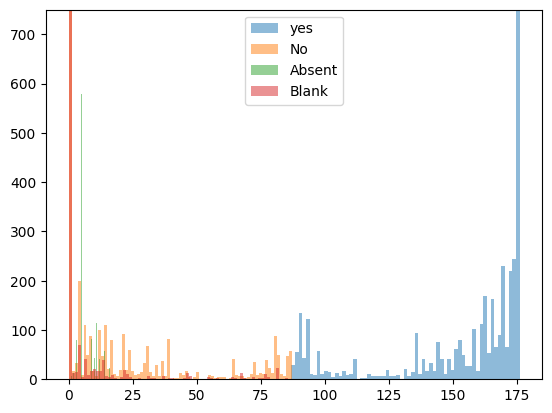

In [59]:
#plot a histogram of the number of yes votes, no votes, absent votes and blank votes for each law
#Only plot the y axis up to 500 as there are more than 3000 instances of no and blank votes
plt.hist(yes_votes, bins=75, alpha=0.5, label='yes')
plt.hist(no_votes, bins=75, alpha=0.5, label='No')
plt.hist(absent_votes, bins=75, alpha=0.5, label='Absent')
plt.hist(blank_votes, bins=75, alpha=0.5, label='Blank')
plt.ylim(0,750)
plt.legend(loc='upper center')
plt.show()


 It is perculiar that there seem to be large "spike" of the number of absent votes per law around 5-8 votes per processing, we look into where the majority of absent votes come from. This is after we have adjusted absent votes so that they are similar to the voting that the members of the similar party vote.

In [60]:
absent_dict = {}
for votings in df_votes_politicians_clean['votes_adjusted']:
    for vote in votings:
        if vote['typeid'] == 3:
            if vote['party'] not in absent_dict:
                absent_dict[vote['party']] = 1
            #If the party is already in the dict, append the typeid to the list of typeids
            else:
                absent_dict[vote['party']] += 1

absent_dict

{'Uden for folketingsgrupperne': 5538,
 'Sambandsflokkurin': 2176,
 'Javnaðarflokkurin': 2280,
 'Siumut': 3027,
 'Inuit Ataqatigiit': 3710,
 'Tjóðveldisflokkurin': 1461,
 'Kristendemokraterne': 413,
 'Liberal Alliance': 130,
 'Enhedslisten': 22,
 'Tjóðveldi': 931,
 'Fólkaflokkurin': 583,
 'Ny Alliance': 207,
 'Nunatta Qitornai': 219,
 'Alternativet': 214,
 'Nye Borgerlige': 24}

This seems reasonable, the vast majority of "pure" absent votes (i.e. entire party voted absent) stem from politicians when they had left a party and may not even bother to vote, along with the the north-atlantern mandates such as Sambandsflokkurin, Javnaðarflokkurin, Inuit Ataqatigiit and Tjóðveldi where there is a precedens that these parties refain from votin on many topics that does not affect Greenland or the Faroe Islands.

We add this column to the main dataframe

In [61]:
df_law_clean['votes_adjusted'] = df_votes_politicians_clean['votes_adjusted'].copy()

### Adding a category to laws
For our further analysis we decided that it would be beneficial to append the another feature, the 'category' of a given law for further filtering. This require a new query and will be added to the DF

In [62]:
def get_law_category(sag_id: int):

    #The key value of the returned json contains the category of the law, other keys are not relevant (meta data etc)
    url = f'https://oda.ft.dk/api/Sag({sag_id})/EmneordSag?$expand=Emneord&$inlinecount=allpages'
    r = requests.get(url)
    category = r.json()['value']
    prev = r.json()['value']
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        category['value'] += r.json()['value']
        prev = r.json()['value']
    
    #may retrn a list of dicts if a given law has multiple categories
    return category


def law_category_list(law_id_list: list):
    #obtain the list of categories that belong to a law, for each sag_id
    law_category_list = [get_law_category(sag_id) for sag_id in law_id_list]

    #make a list comprehension that extracts a list of category names for each law
    category_name_list = [[x['Emneord']['emneord'] for x in y] for y in law_category_list]

    #make a list comprehension that extracts a list of category names for each law
    category_id_list = [[x['Emneord']['id'] for x in y] for y in law_category_list]
    #Add the list of category names to the dataframe

    return category_name_list, category_id_list

category_name_list, category_id_list = law_category_list(df_law_clean['sag_id'].tolist())


In [63]:
df_law_clean['law_category'] = category_name_list
df_law_clean['law_category_id'] = category_id_list

<BarContainer object of 50 artists>

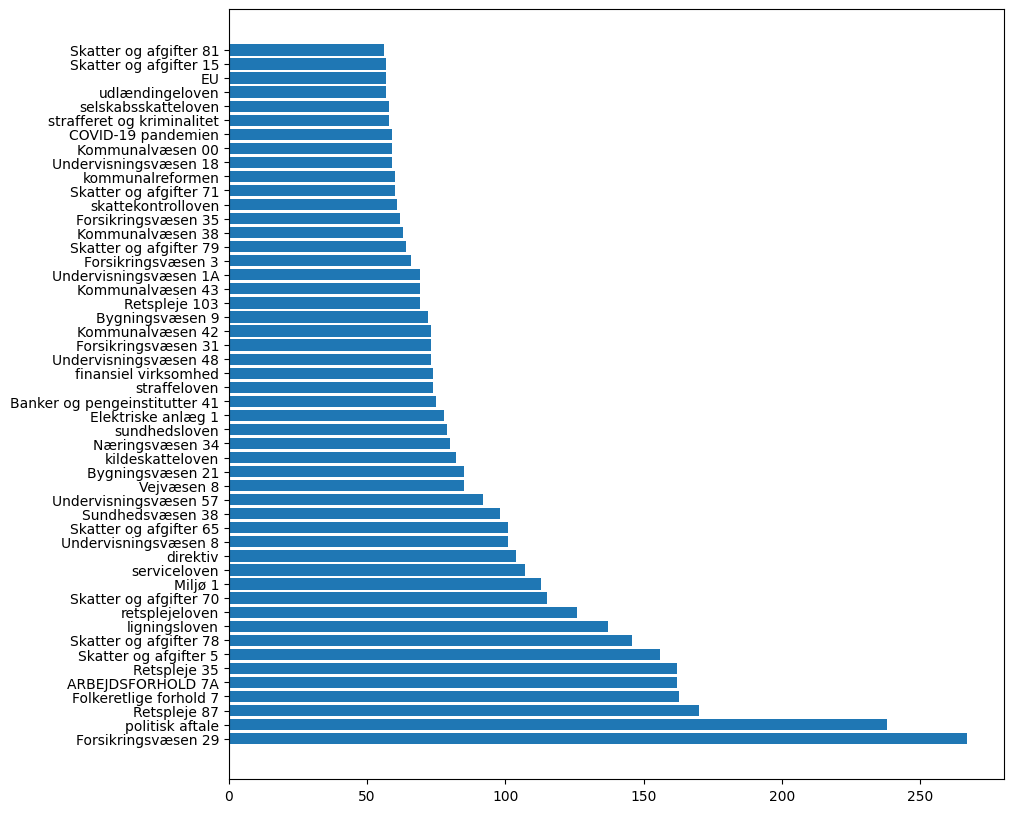

In [64]:

#make historgram of the number of laws in each category
category_dict = defaultdict()
for category_list in df_law_clean['law_category']:
    for category in category_list:
        if category not in category_dict:
            category_dict[category] = 1
        else:
            category_dict[category] += 1
#take top 50 categories
top_50_categories = sorted(category_dict.items(), key=lambda x: x[1], reverse=True)[:50]

fig, ax = plt.subplots(figsize=(10,10))
ax.barh([x[0] for x in top_50_categories], [x[1] for x in top_50_categories])


In [65]:
#Count the number of unique categories
len(set([x for y in df_law_clean['law_category'] for x in y]))

4517

#### Merging law categories
Turns out we have 4517 unique law categories. Many laws are named 'Law category #some number" , like Retspleje 45, Retspleje 35 etc., we will merge these into one category, as well as categories like Undervisningsvaesen 1A, Undervisningsvaesen 1B etc.

In [66]:
#Use regex to search for any numbers in the category name and remove them and the previous space, along with any following characters
df_law_clean['law_category_clean'] = df_law_clean['law_category'].apply(lambda x: [re.sub(r'\s+\d+\w*', '', y) for y in x])

<BarContainer object of 50 artists>

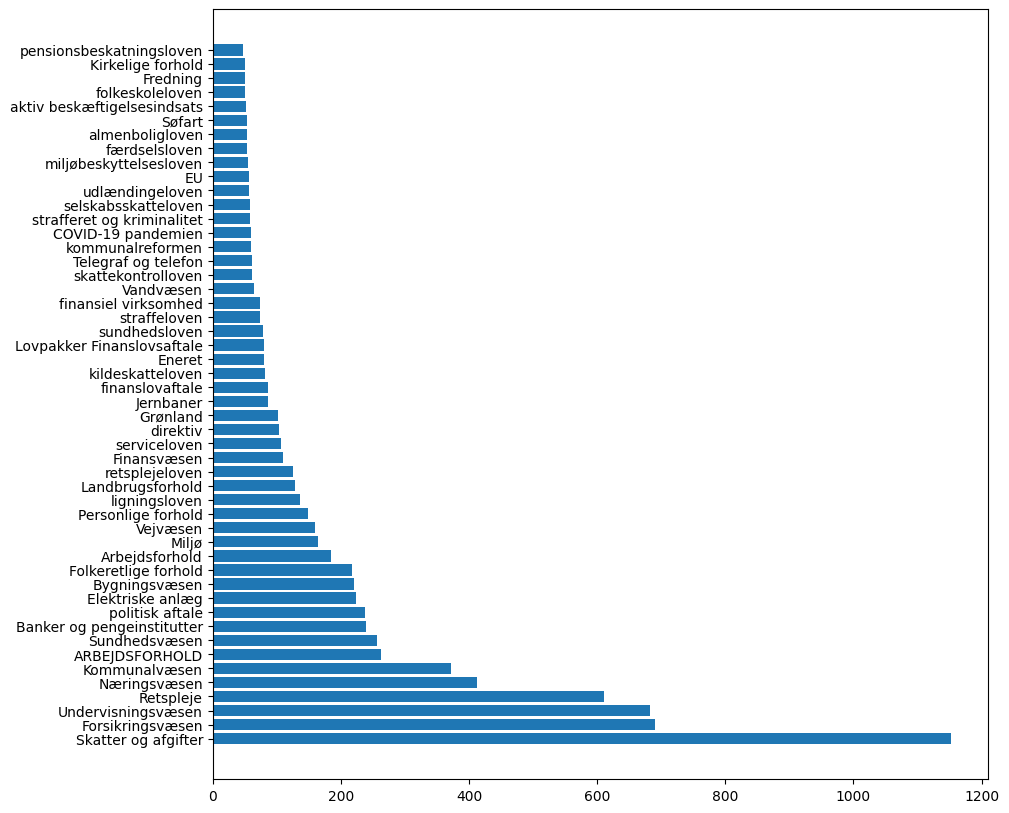

In [67]:
#make historgram of the number of laws in each category
category_dict = {}
for category_list in df_law_clean['law_category_clean']:
    for category in category_list:
        if category not in category_dict:
            category_dict[category] = 1
        else:
            category_dict[category] += 1
#take top 50 categories
top_50_categories = sorted(category_dict.items(), key=lambda x: x[1], reverse=True)[:50]

fig, ax = plt.subplots(figsize=(10,10))
ax.barh([x[0] for x in top_50_categories], [x[1] for x in top_50_categories])


In [68]:
#Count the number of unique categories
len(set([x for y in df_law_clean['law_category_clean'] for x in y]))

4196

Reduced the total number of categories by ~300 to 4196. For our further analysis we will primarily dive into a specific category such as 'Miljoe' or 'Skatter and Afgifter'

# 3) Creating a network graph
We merge the column of votings for each law, and as we will be matching afstemnings_id with aktør_id there is a potential conflict, because these integer values overlap (there are laws with the same ID as actors). For that reason we will add a new law_id column with a prefix. 

In [69]:
#create a new column called afstemnings_id_pfix with a prefix p added to afstemnings_id
df_law_clean['afstemnings_id_pfix'] = df_law_clean['afstemnings_id'].apply(lambda x: 'p' + str(x))


## LOAD THIS PICKLE 
It combines most of the above data collection an cleaning

In [70]:
#save law info as pickle file
#Pickle size problem, drop the following columns to reduce file size

#df_law_clean.drop(columns=['law_category'], inplace=True)
#df_law_clean.drop(columns=['votes_combined_info'], inplace=True)
#drop the following columns as well:
#df_law_clean.drop(['category_name_list', 'category_id_list', 'law_category_name', 'dato_afst_opd', 'dato_sag_opd', 'lovnummer', 'sagstrin_id', 'vedtaget'], axis=1, inplace=True)

#import pickle
#with open('df_law_clean.pickle', 'wb') as f:
#    pickle.dump(df_law_clean, f)

#load law info as pickle file
with open('df_law_clean.pickle', 'rb') as f:
        df_law_clean = pickle.load(f)

In [71]:
df_law_clean.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

In [72]:
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 1 (yes)
yes_votes = [len([x for x in y if x['typeid'] == 1]) for y in df_law_clean['votes_adjusted']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 2 (no)
no_votes = [len([x for x in y if x['typeid'] == 2]) for y in df_law_clean['votes_adjusted']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 3 (absent)
absent_votes = [len([x for x in y if x['typeid'] == 3]) for y in df_law_clean['votes_adjusted']]
#Count the number of elements in the list of dicts in the votes_combined_info column that has a typeid of 4 (blank)
blank_votes = [len([x for x in y if x['typeid'] == 4]) for y in df_law_clean['votes_adjusted']]

In [73]:
df_law_clean.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

In [118]:
#Create a color map for the parties
def create_color_map():

    #Create a color map for the parties
    color_map = {}
    color_map['Socialdemokratiet'] = 'firebrick'
    color_map['Venstre, Danmarks Liberale Parti'] = 'blue'
    color_map['Dansk Folkeparti'] = 'yellow'
    color_map['Enhedslisten'] = 'orange'
    color_map['Nye Borgerlige'] = 'teal'
    color_map['Ny Alliance'] = 'cyan'
    color_map['Liberal Alliance'] = 'cyan'
    color_map['Radikale Venstre'] = 'darkmagenta'
    color_map['Socialistisk Folkeparti'] = 'palevioletred'
    color_map['Danmarksdemokraterne'] = 'steelblue'
    color_map['Alternativet'] = 'green'
    color_map['Moderaterne'] = 'mediumpurple'
    color_map['Det Konservative Folkeparti'] = 'yellowgreen'

    #små partier og uspecificeret
    color_map['Frie Grønne'] = 'darkgrey'
    color_map['unknown'] = 'black'
    color_map['Uden for folketingsgrupperne'] = 'grey'
    color_map['Javnaðarflokkurin'] = 'darkgrey'
    color_map['Tjóðveldisflokkurin'] = 'darkgrey'
    color_map['Tjóðveldi'] = 'darkgrey'
    color_map['Fólkaflokkurin'] = 'darkgrey'
    color_map['Kristendemokraterne'] = 'darkgrey'
    color_map['Siumut'] = 'darkgrey'
    color_map['Sambandsflokkurin'] = 'darkgrey'
    color_map['Inuit Ataqatigiit'] = 'darkgrey'
    color_map['Nunatta Qitornai'] = 'darkgrey'

    return color_map

color_map = create_color_map()


In [75]:
import networkx as nx

#We first create the network directly with the unique actor IDs

def create_bipartite_graph(df):
    G = nx.Graph()
    #loop through each row of the df:
    for index, row in df.iterrows():
        #loop through each vote in the row
        #add a node with afstemnings_id as name and lovnummer, titel and periode as attribute and set attribute 'type' as law
        G.add_node(row['afstemnings_id_pfix'], lovnummer=row['lovnummer_num'], title=row['titel_kort'], periode_id = row['periode_id'], type='law', bipartite=0)
        for vote in row['votes_adjusted']:
            #add edge between the law and the politician if voteid = 1 (yes)
            if vote['typeid'] == 1:
                #if node does not exist, add node with politician id as name and party as attribute and set attribute 'type' as politician
                #if vote['aktor_id'] not in G:
                #    G.add_node(vote['aktor_id'], party=vote['party'], type='politician', bipartite=1, name=vote['name'])
                G.add_edge(row['afstemnings_id_pfix'], vote['aktørid'])
                #set attribute 'type' as politician
                #set node type to politician
                G.nodes[vote['aktørid']]['type'] = 'politician'
 
    
    return G

G_bipartite_noattributes = create_bipartite_graph(df_law_clean)


In [77]:

#function to loop through all politician nodes of the network and set attributes accordingly
#The function is split from the creation of the network, so that setting the attributes is not repeated for every law when politicians nodes are added
def set_politician_attributes(G):
    for node in G.nodes():
        if G.nodes[node]['type'] == 'politician':
            #set attribute 'party' as the party of the politician
            G.nodes[node]['party'] = politician_clean_df[politician_clean_df['politician_id'] == node]['party'].values[0]
            #set attribute 'name' as the name of the politician
            G.nodes[node]['name'] = politician_clean_df[politician_clean_df['politician_id'] == node]['politician_name'].values[0]
            #set attribute 'color' as the color of the party
            #Hacky way just to take the first element on the party list and assign color accordingly
            G.nodes[node]['color'] = color_map[list(G.nodes[node]['party'].values())[0]]
            #set node bipartite to 1
            G.nodes[node]['bipartite'] = 1
    return G

G_bipartite = set_politician_attributes(G_bipartite_noattributes)

In [78]:
#Verifying that the network is bipartite
nx.is_bipartite(G_bipartite)

True

In [79]:
#export the network to csv
#nx.write_edgelist(G_bipartite, "G_bipartite.csv", delimiter=",")
nx.write_gpickle(G_bipartite, "G_bipartite.gpickle", protocol=4)

### Some network stats

In [80]:
#import the network from g_partite.gpickle
G_bipartite = nx.read_gpickle("G_bipartite.gpickle")

In [81]:
#total number of nodes in the network
print(f'The network has {len(G_bipartite.nodes())} nodes')
#this many are politicians
print(f'Of which {len([G_bipartite.nodes[node]["name"] for node in G_bipartite.nodes() if G_bipartite.nodes[node]["type"] == "politician"])} are politicians')
#number of edges
print(f'The network has {len(G_bipartite.edges())} edges, each indicating a yes vote')

The network has 4350 nodes
Of which 588 are politicians
The network has 574441 edges, each indicating a yes vote


Convertin absent votes to yes votes increased edges in network from 355k, to more than 574k. 

In [82]:
#number of isolated nodes
print(f'The network has {len(list(nx.isolates(G_bipartite)))} isolated nodes')
#print the isolated nodes
print(list(nx.isolates(G_bipartite)))

#Der mangler simpelthen afstemninggsinfo fra nogle af lovene, jeg har checket flg: 7901, 7907, 7989, 8044. Spørg evt. Anders fra folketinget hvordan det kan være, lovende ser umiddelbart alm. ud

The network has 0 isolated nodes
[]


In [83]:
#remove the isolated nodes
G_bipartite.remove_nodes_from(list(nx.isolates(G_bipartite)))

In [84]:
#function from nx that splits a bipartite graph into two sets of nodes
law_nodes, politician_nodes = nx.bipartite.sets(G_bipartite)

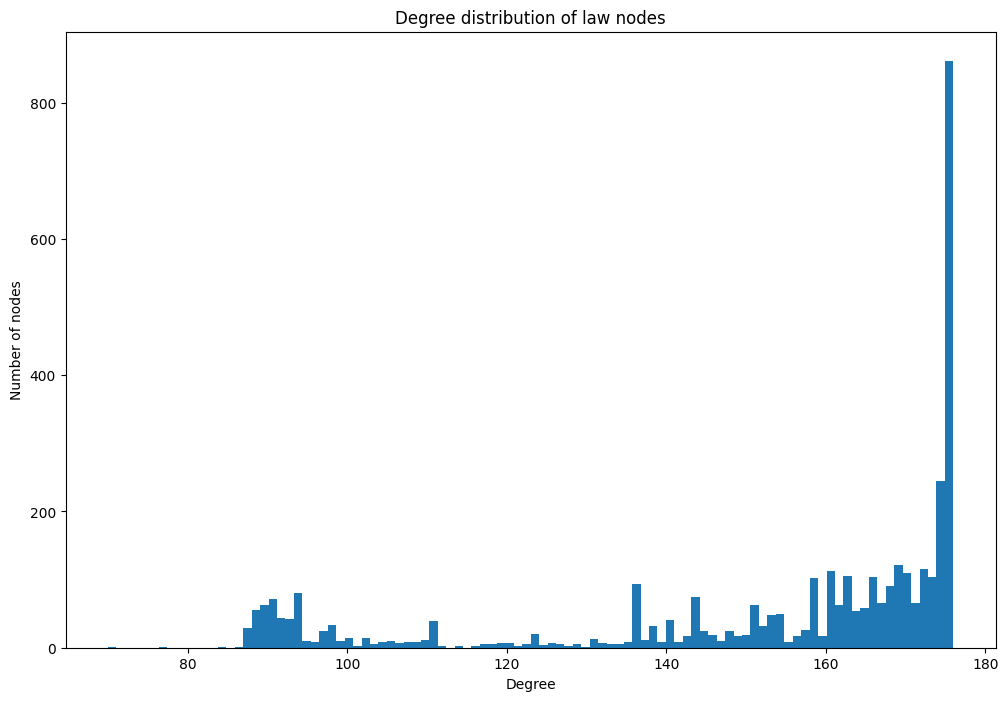

In [85]:
#Plot the degree distribution of nodes in the network
#Since we have a bipartite network with relatively few politcians, connecting each to hundreds of laws, we split the distribution of politician and law nodes seperately

#degree distribution of law nodes
#plot the degree distribution of the law nodes
plt.figure(figsize=(12,8))
plt.hist([G_bipartite.degree(node) for node in law_nodes], bins=100)
plt.title('Degree distribution of law nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
#set size of the figure to 10x10

plt.show()

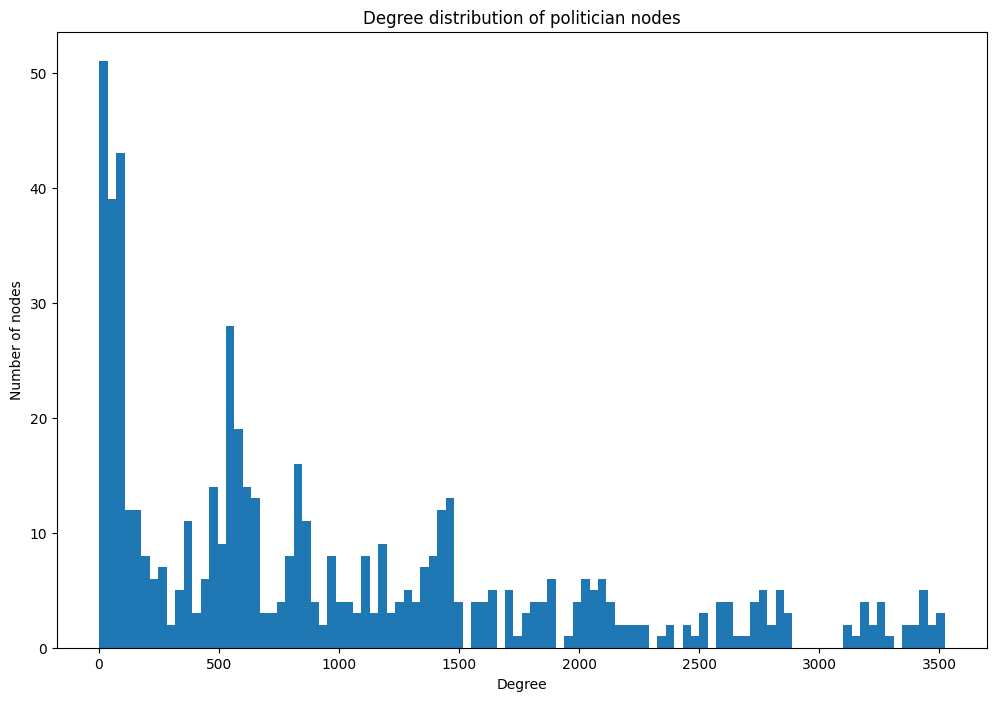

In [86]:
#plot degree distribution of politician nodes
plt.figure(figsize=(12,8))
plt.hist([G_bipartite.degree(node) for node in politician_nodes], bins=100)
plt.title('Degree distribution of politician nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()


In [93]:
top_10_yes = sorted(G_bipartite.degree, key=lambda x: x[1], reverse=True)[:10]
#slice the list to only get the last element of each tuple
top_10_yes = [node[0] for node in top_10_yes]

In [94]:
[(G_bipartite.nodes[x]['name'],list(G_bipartite.nodes[x]['party'].values())[0]) for x in top_10_yes]

[('Erling Bonnesen', 'Venstre, Danmarks Liberale Parti'),
 ('Eva Kjer Hansen', 'Venstre, Danmarks Liberale Parti'),
 ('Hans Christian Schmidt', 'Venstre, Danmarks Liberale Parti'),
 ('Lars Christian Lilleholt', 'Venstre, Danmarks Liberale Parti'),
 ('Troels Lund Poulsen', 'Venstre, Danmarks Liberale Parti'),
 ('Bertel Haarder', 'Venstre, Danmarks Liberale Parti'),
 ('Jacob Jensen', 'Venstre, Danmarks Liberale Parti'),
 ('Claus Hjort Frederiksen', 'Venstre, Danmarks Liberale Parti'),
 ('Kristian Pihl Lorentzen', 'Venstre, Danmarks Liberale Parti'),
 ('Michael Aastrup Jensen', 'Venstre, Danmarks Liberale Parti')]

## We now investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

After having check a few periods, it seems to make sense to make a threshold at 90% of max votes

In [99]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)

In [95]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [96]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [97]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [101]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)

df['votes_adjusted'].isna().sum()

0

In [102]:
#New function to filter active politicians
#overwrite the votes_adjusted column to only contain active politicians in the df_active dataframe
df['votes_adjusted_active'] = [ [vote for vote in row['votes_adjusted'] if vote['aktørid'] in dict_active_politicians[row['periode_id']]] for index, row in df.iterrows()]


In [103]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


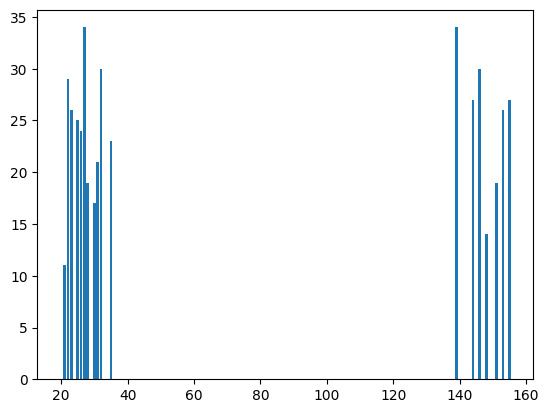

The average number of politicians dropped per period is 19.818181818181817


In [104]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

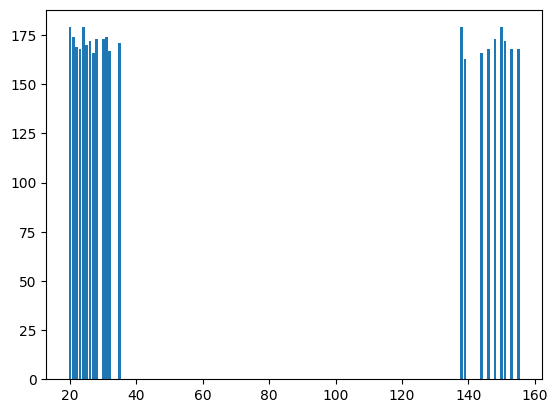

The average number of politicians that we consider per period is 171.4090909090909


In [105]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [106]:
#load data from df_law_active.pickle
with open('df_law_active.pickle', 'rb') as f:
    df = pickle.load(f)

In [108]:
#create a networkx graph for period 32
periode_id_plot = 32
df_periode = df[df['periode_id'] == periode_id_plot]

#clear G
G = nx.Graph()

G = create_bipartite_graph(df_periode)

G = set_politician_attributes(G)

In [109]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [111]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)


No isolate nodes


In [113]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))

2


In [ ]:
widths = nx.get_edge_attributes(G_uni, 'weight')
max_width = max(widths.values())
#Normalize the widths using a list comprehension
widths_scaled_values = [width/max_width for width in widths.values()]


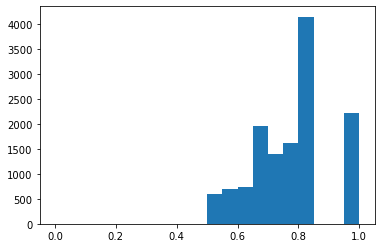

In [ ]:
#print a histogram of the widths with 0.05 bins
plt.hist(widths_scaled_values, bins= np.arange(0,1.05,0.05))
plt.show()

# 4) Clustering algortithm

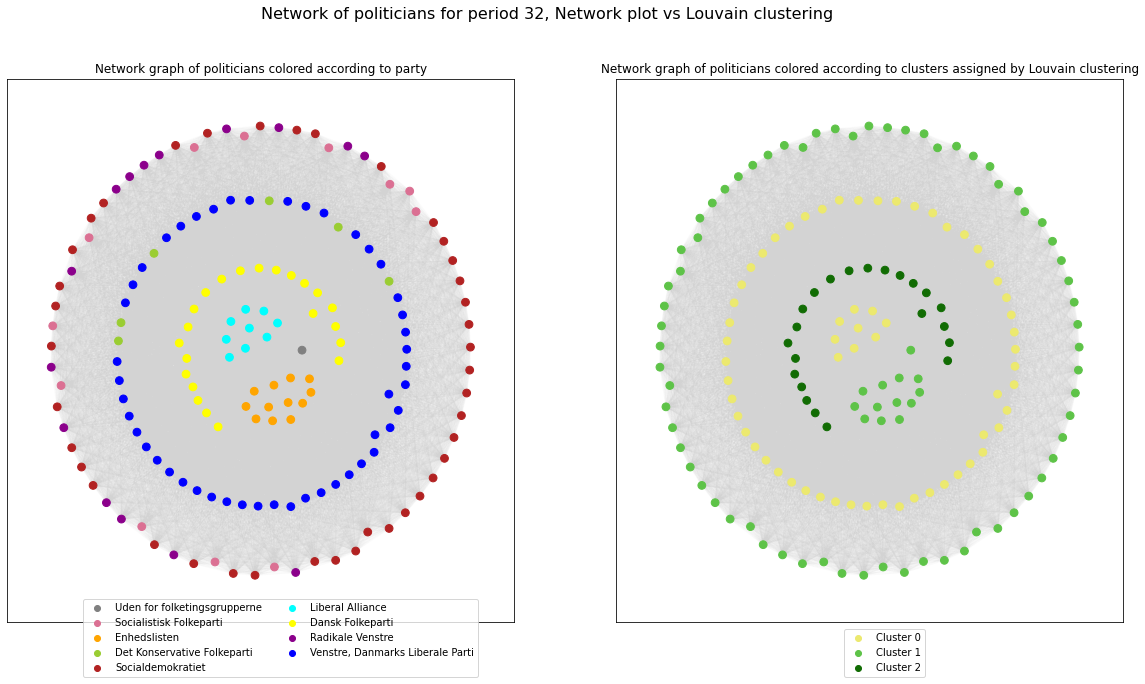

In [ ]:
widths = nx.get_edge_attributes(G_uni, 'weight')
nodelist = G_uni.nodes()

clustering_color = {}
for cluster in set(partition.values()):
    clustering_color[cluster] = [np.random.rand(3,)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'Network of politicians for period {periode_id_plot}, Network plot vs Louvain clustering', fontsize=16)

pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)

nx.draw_networkx_nodes(G_uni, node_size = 60, pos=pos, node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()],alpha=1.0, ax=ax1)

nx.draw_networkx_edges(G_uni,pos,
                       edgelist = widths.keys(),
                       width=widths_scaled_values,
                       edge_color='#d3d3d3',
                       alpha=0.1, ax=ax1)

nx.draw_networkx_nodes(G_uni, node_size = 60, pos=pos, node_color = [clustering_color[partition[node]] for node in G_uni.nodes()],alpha=1.0, ax=ax2)

nx.draw_networkx_edges(G_uni,pos,
                       edgelist = widths.keys(),
                       width=widths_scaled_values,
                       edge_color='#d3d3d3',
                       alpha=0.1, ax=ax2)

ax2.set_title('Network graph of politicians colored according to clusters assigned by Louvain clustering')

#set of unique parties
#REMEMBER TO SET PERIODE_ID_PLOT FOR CORRECT PARTY LEGENDS
parties = set([G_uni.nodes[node]['party'][periode_id_plot] for node in G_uni.nodes()])
#add legend to ax1 with party name and color
for party in parties:
    ax1.scatter([], [], c=color_map[party], label=party)
ax1.legend(loc=(0.15,-0.1), ncol=2, borderaxespad=5)

#Iterate over key and values in clustering_color and add legend to ax2
for cluster, color in clustering_color.items():
    label_cluster = f'Cluster {cluster}'
    ax2.scatter([], [], c=color, label=label_cluster)
ax2.legend(loc=(0.45,-0.1), borderaxespad=5)

ax1.set_title('Network graph of politicians colored according to party')

plt.show()

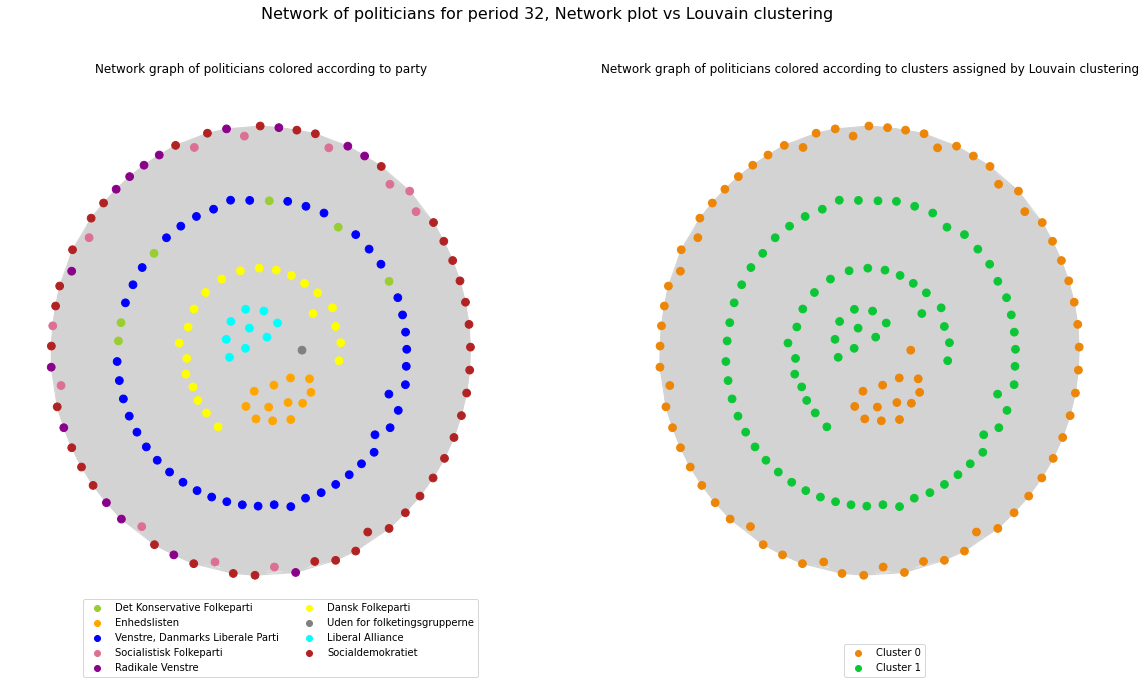

In [ ]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#create random colors for the clusters

clustering_color = {}
for cluster in set(partition.values()):
    clustering_color[cluster] = [np.random.rand(3,)]


#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)

nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [clustering_color[partition[node]] for node in G_uni.nodes()], ax=ax2)

nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax1)

ax2.set_title('Network graph of politicians colored according to clusters assigned by Louvain clustering')

#set of unique parties
#REMEMBER TO SET PERIODE_ID_PLOT FOR CORRECT PARTY LEGENDS
parties = set([G_uni.nodes[node]['party'][periode_id_plot] for node in G_uni.nodes()])
#add legend to ax1 with party name and color
for party in parties:
    ax1.scatter([], [], c=color_map[party], label=party)
ax1.legend(loc=(0.15,-0.1), ncol=2, borderaxespad=5)

#Iterate over key and values in clustering_color and add legend to ax2
for cluster, color in clustering_color.items():
    label_cluster = f'Cluster {cluster}'
    ax2.scatter([], [], c=color, label=label_cluster)
ax2.legend(loc=(0.4,-0.1), borderaxespad=5)

ax1.set_title('Network graph of politicians colored according to party')
fig.suptitle(f'Network of politicians for period {periode_id_plot}, Network plot vs Louvain clustering', fontsize=16)
plt.show()

# 5) Temporal analysis of party collaboration

We first plot the clustering over time for each period and check if the same parties are in the same clusters and if certain individuals are not in the same cluster as their party

In [152]:
with open('df_law_active_rune.pickle', 'rb') as f:
    df = pickle.load(f)

#loading politician info from pickle politician_df_clean.pkl
with open('politician_df_clean.pkl', 'rb') as f:
    politician_df = pickle.load(f)

politician_df.head()

#set the index to politician_id
politician_df = politician_df.set_index('politician_id')

In [154]:
#remove nan
df = df[df['votes_adjusted_active'].notna()]

#count nan
df['votes_adjusted_active'].isna().sum()

0

In [153]:
#We make a dict where we have the periode_id as key and the aktør_id with their party and partition as value
partition_all_periods = pd.DataFrame()

#unique periods
periods = df['periode_id'].unique()

trouble_ids = []

for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)
    
    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() 

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #Do clustering on the graph using the Louvain algorithm
    partition = community_louvain.best_partition(G_uni)

    
    period_dict = defaultdict()
    for id in partition.keys():
        try:
            #get party of id
            party = politician_df.loc[id]['party'][periode_id]
            period_dict[id] = [party, partition[id],periode_id]
            period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
        except KeyError:
            trouble_ids.append({'id':id, 'periode_id':periode_id})
            print(f'KeyError for id {id} and periode_id {periode_id}')
            pass

    
    partition_all_periods = partition_all_periods.append(period_df)



Working on periode_id 32
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 31
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 30
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 28
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 35
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 27
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 138
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 139
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 144
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 146
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 26
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)
C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 24
No isolate nodes
Working on periode_id 25
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 23
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 22
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 21
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 20
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 148
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 150
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 151
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 153
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 155
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\91861201.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


### Identifying politicians who are not assigned the same cluster as the rest of their party

In [156]:
#This function finds non-conformers for all parties for all periods
def find_non_conformers(partition_all_periods):
    non_conformers = pd.DataFrame()
    parties = partition_all_periods['party'].unique()
    for party in parties:
        #get subset of partition_all_periods for the party
        df_party = partition_all_periods[partition_all_periods['party'] == party]
        #get the partition number for the party for each period
        periods = df_party['periode_id'].unique()
        for period in periods:
            #get subset of partition_all_periods for the party and period
            df_period = df_party[df_party['periode_id'] == period]
            #get the partition number for the party
            party_partition_number = df_period['partition'].unique()[0]
            #get the subset of partition_all_periods for the party and period where the partition number is not the same as the party
            non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
    return non_conformers

non_conformers = find_non_conformers(partition_all_periods)

#We add the politician name to the non_conformers
for id in non_conformers.index:
    non_conformers.loc[id, 'politician_name'] = politician_df.loc[id]['politician_name']
non_conformers

C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\2348444063.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_21424\2348444063.py:16: FutureWarning: The fram

party  partition  periode_id  \
13727                  Enhedslisten          2          35   
201               Socialdemokratiet          1          32   
304               Socialdemokratiet          2          32   
351               Socialdemokratiet          1          32   
363               Socialdemokratiet          1          32   
...                             ...        ...         ...   
117    Uden for folketingsgrupperne          0         155   
145    Uden for folketingsgrupperne          0         155   
225    Uden for folketingsgrupperne          0         155   
18691  Uden for folketingsgrupperne          0         155   
18692  Uden for folketingsgrupperne          0         155   

                   politician_name  
13727                 Sarah Nørris  
201                  Thomas Jensen  
304                     Jacob Lund  
351        Sophie Hæstorp Andersen  
363              Jacob Bjerregaard  
...                            ...  
117    Simon Emil Ammitzbøll-Bille  
145           Lars Løkke Rasmussen  
225                     Uffe Elbæk  
18691            Sikandar Siddique  
18692               Susanne Zimmer  

[136 rows x 4 columns]

### There are so few that we decide to ignore them an only focus on parties

In [157]:
#We check which partition people from socialdemokratiet are in
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')


partition
0    597
1    297
2    150
dtype: int64

### We now prepare for plotting by arrangign clusters over periods such that Socialdemokratiet is fixed at 1 

In [ ]:
#We check which partition people from socialdemokratiet are in
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')


partition
0    716
1    220
dtype: int64

In [ ]:

#This means we have to change it such that the partition number is consistent across periods

#First we find out which partitition number is most common for socialdemokratiet for each period
soc_partition = partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].groupby('periode_id').agg(lambda x:x.value_counts().index[0])

In [ ]:
#For all periods where the partition number is not 1, we change it to 1 and we change the partition number for the other parties accordingly
for periode_id in soc_partition.index:
    #get subset of partition_all_periods for the periode_id
    df_period = partition_all_periods[partition_all_periods['periode_id'] == periode_id]
    #get the partition number for socialdemokratiet
    soc_partition_number = soc_partition.loc[periode_id]['partition']
    #if the partition number is not 1, we change it to 1
    if soc_partition_number != 1:
        #We first move all the parities with soc_partition_number to partition 10 (which is not used)
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == soc_partition_number), 'partition'] = 10
        #We then move all the parties with partition number 1 to soc_partition_number
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 1), 'partition'] = soc_partition_number
        #We then move all the parties with partition number 10 to 1
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 10), 'partition'] = 1

In [ ]:
#We check that it worked
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')
#This means that two persons from Socialdemokratiet were not assigned to the same parititon as the rest of the party


partition
1    932
0      4
dtype: int64

In [ ]:
#In general there are quite few non-conformers. So when plotting the graph, we will simply plot each party as a group

#We save the partition_all_periods as a pickle
partition_all_periods.to_pickle('partition_all_periods.pkl')

In [ ]:
#We exctract the most common partition for all parties for all periods in partition_all_periods
party_partition = partition_all_periods.groupby(['party', 'periode_id']).agg(lambda x:x.value_counts().index[0])
party_partition['partition']

party                             periode_id
Alternativet                      138           1
                                  139           1
                                  144           0
                                  146           2
                                  148           0
                                               ..
Venstre, Danmarks Liberale Parti  148           2
                                  150           1
                                  151           0
                                  153           0
                                  155           0
Name: partition, Length: 223, dtype: int64

In [ ]:
#count laws in each period
df.groupby('periode_id').count()['afstemnings_id']


periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

In [ ]:
common_partition = defaultdict()
#unique parties 
parties = partition_all_periods['party'].unique()
#drop Tjóðveldisflokkurin, 'Inuit Ataqatigiit',  'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne',Fólkaflokkurin and 'Uden for folketingsgrupperne',
parties = parties[~np.isin(parties, ['Tjóðveldisflokkurin', 'Inuit Ataqatigiit', 'Sambandsflokkurin', 'Siumut', 'Kristendemokraterne','Fólkaflokkurin',  'Uden for folketingsgrupperne'])]

In [ ]:
party_period = defaultdict()
periods = partition_all_periods['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 7, 150])]
for party in parties:
    #get a subset of party_partition for the party
    df_party = party_partition.loc[party]
    for period in periods:
        #Check that df_party has the period
        if period in df_party.index:
            #get the partition number for the party and period
            party_period[(party, period)] = df_party.loc[period]['partition']
        else:
            #if the party did not exist in the period, we set the partition number to 0
            party_period[(party, period)] = None

In [ ]:
party_period

defaultdict(None,
            {('Enhedslisten', 32): 1,
             ('Enhedslisten', 31): 1,
             ('Enhedslisten', 30): 1,
             ('Enhedslisten', 28): 1,
             ('Enhedslisten', 35): 1,
             ('Enhedslisten', 27): 1,
             ('Enhedslisten', 138): 1,
             ('Enhedslisten', 139): 1,
             ('Enhedslisten', 144): 0,
             ('Enhedslisten', 146): 2,
             ('Enhedslisten', 26): 1,
             ('Enhedslisten', 25): 1,
             ('Enhedslisten', 23): 1,
             ('Enhedslisten', 22): 1,
             ('Enhedslisten', 21): 1,
             ('Enhedslisten', 20): 1,
             ('Enhedslisten', 148): 0,
             ('Enhedslisten', 151): 1,
             ('Enhedslisten', 153): 1,
             ('Enhedslisten', 155): 1,
             ('Socialdemokratiet', 32): 1,
             ('Socialdemokratiet', 31): 1,
             ('Socialdemokratiet', 30): 1,
             ('Socialdemokratiet', 28): 1,
             ('Socialdemokratiet', 35): 1,

### We now plot the parties clustering over time
First we identify the dates corresponding to each period

In [ ]:
#We look through the df dato_sagstrin that is a datetime format and we extract the min and max date for each periode_id
periods_dict = defaultdict()
for period in periods:
    #get subset of dato_sagstrin for the period
    df_period = df[df['periode_id'] == period]
    #get the min and max date
    min_date = df_period['dato_sagstrin'].min()
    #convert to datetime
    min_date = datetime.datetime.strptime(min_date[:-9], '%Y-%m-%d')
    max_date = df_period['dato_sagstrin'].max()
    #convert to datetime
    max_date = datetime.datetime.strptime(max_date[:-9], '%Y-%m-%d')
    #find the date in the middle of the period
    middle_date = min_date + (max_date - min_date)/2
    periods_dict[period] = [min_date, middle_date, max_date]
 



In [ ]:
#sort the periods_dict by the middle date
periods_dict = {k: v for k, v in sorted(periods_dict.items(), key=lambda item: item[1][1])}
print(periods_dict)

{20: [datetime.datetime(2004, 11, 16, 0, 0), datetime.datetime(2004, 12, 1, 12, 0), datetime.datetime(2004, 12, 17, 0, 0)], 21: [datetime.datetime(2005, 3, 17, 0, 0), datetime.datetime(2005, 5, 2, 0, 0), datetime.datetime(2005, 6, 17, 0, 0)], 22: [datetime.datetime(2005, 11, 3, 0, 0), datetime.datetime(2006, 2, 16, 12, 0), datetime.datetime(2006, 6, 2, 0, 0)], 23: [datetime.datetime(2006, 11, 21, 0, 0), datetime.datetime(2007, 2, 25, 0, 0), datetime.datetime(2007, 6, 1, 0, 0)], 25: [datetime.datetime(2007, 12, 14, 0, 0), datetime.datetime(2008, 4, 27, 0, 0), datetime.datetime(2008, 9, 9, 0, 0)], 26: [datetime.datetime(2008, 10, 10, 0, 0), datetime.datetime(2009, 2, 12, 12, 0), datetime.datetime(2009, 6, 18, 0, 0)], 27: [datetime.datetime(2009, 11, 19, 0, 0), datetime.datetime(2010, 3, 3, 12, 0), datetime.datetime(2010, 6, 16, 0, 0)], 28: [datetime.datetime(2010, 11, 18, 0, 0), datetime.datetime(2011, 3, 10, 12, 0), datetime.datetime(2011, 7, 1, 0, 0)], 30: [datetime.datetime(2011, 11, 

In [ ]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [ ]:
elections = [datetime.datetime(2005, 11, 13, 0, 0),
 datetime.datetime(2007, 11, 18, 0, 0),
 datetime.datetime(2011, 11, 15, 0, 0),
 datetime.datetime(2015, 11, 21, 0, 0),
 datetime.datetime(2019, 11, 5, 0, 0),
 datetime.datetime(2022, 11, 1, 0, 0)]

In [ ]:
#Make new party order from most left to most right (aproximately)
parties = ['Enhedslisten','Socialistisk Folkeparti', 'Alternativet','Radikale Venstre', 'Socialdemokratiet', 'Venstre, Danmarks Liberale Parti', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige']

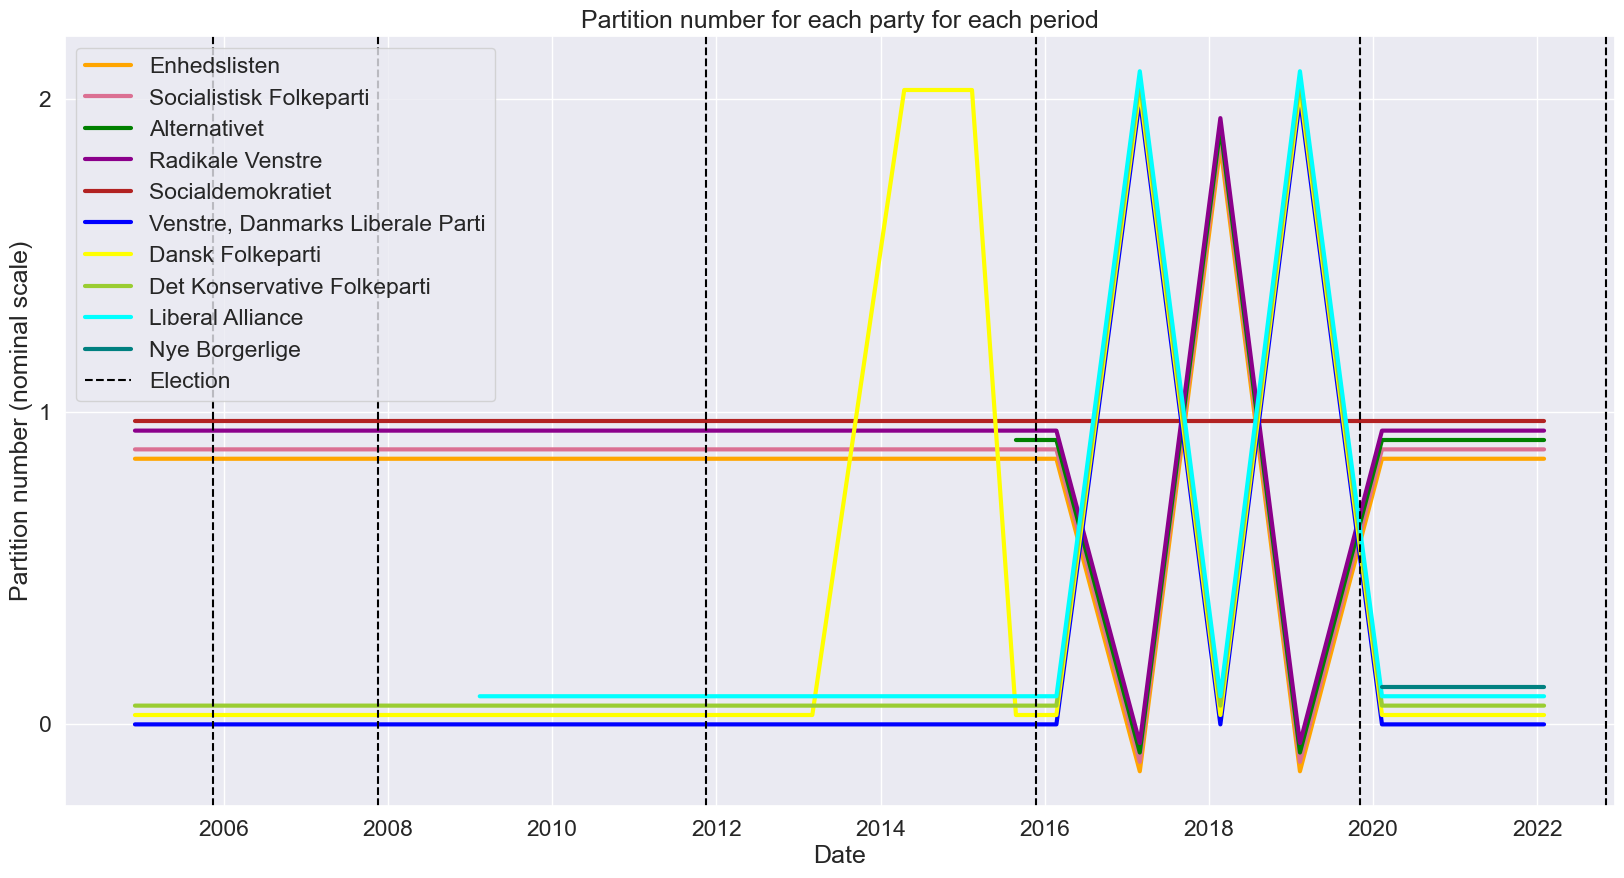

In [ ]:
#We plot all the parties
import seaborn as sns

sns.set_style("darkgrid")

#set text size and font style to arial
sns.set(font = 'Arial')
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0
constant = 0.15
for party in parties:
    #We get the partition number for the party for each period
    partition_number = [party_period[(party, period)] for period in periods]
    #add offset if the entries in partition_number are not None
    partition_number = [x + offset - constant if x is not None else x for x in partition_number]
    #We plot the partition number for the party for each period
    ax.plot(middle_date, partition_number, label = party, color = color_map[party], linewidth = 3)
    offset = offset + 0.03
#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')

ax.legend()


#make y ticks only be 0, 1, 2
ax.set_yticks([0, 1, 2])
ax.set_xlabel('Date')
ax.set_ylabel('Partition number (nominal scale)')
ax.set_title('Partition number for each party for each period')
plt.show()


### We now move onto clusterting distance from Socialdemokratiet

In [ ]:
#get laws per period
df.groupby('periode_id').count()['afstemnings_id']

periode_id
20      80
21     162
22     222
23     202
24       1
25     186
26     207
27     217
28     205
30     189
31     228
32     200
35     173
138      7
139    183
144    215
146    240
148    219
150      1
151    145
153    252
155    162
Name: afstemnings_id, dtype: int64

There are a number of laws during corona where the aktørid was not stored.
We remove these laws

In [ ]:
#check whether all nodes in G_uni.nodes() have a party
for node in G_uni.nodes():
    try: 
        G_uni.nodes[node]['party'][153]
    except KeyError:
        print(node)

19809


In [ ]:
#unique periods
periods = df['periode_id'].unique()
#remove periods 24, 7 and  150
periods = periods[~np.isin(periods, [24, 138, 150])]


distance_all_periods = defaultdict()

right_wing_parites = ['Venstre, Danmarks Liberale Parti', 'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Liberal Alliance', 'Nye Borgerlige']


for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    #remove_isolate_nodes(G)

    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    if periode_id == 153:
        #remove nodes 19809
        G_uni.remove_nodes_from([19809])
        #also remove the edges between 19809 and the other nodes
        G_uni.remove_edges_from([(19809, node) for node in G_uni.nodes()])
        #also remove the edges between the other nodes and 19809
        G_uni.remove_edges_from([(node, 19809) for node in G_uni.nodes()])

    #We take all social democrats as a grouip
    soc_politicians = [node for node in G_uni.nodes() if G_uni.nodes[node]['party'][periode_id] == 'Socialdemokratiet']
    
    #other_parties = [party for party in parties if party != 'Socialdemokratiet']
    distances = defaultdict()
    #We calculate the average weight of the edges between the social democrats and the other parties
    for party in parties:
        #get the nodes for the party
        nodes_party = [node for node in G_uni.nodes if G_uni.nodes[node]['party'][periode_id] == party]
        if len(nodes_party) < 3: #remove parties with less than 3 politicians
            continue
        #calculate the average weight of the edges between the social democrats and all parties including themselves
        try: 
            average_weight = np.mean([G_uni.edges[(soc_politician, node)]['weight'] for soc_politician in soc_politicians for node in nodes_party if soc_politician != node])
        except KeyError:
            average_weight = []
            number_of_bad_edges = 0
            for soc_politician in soc_politicians:
                for node in nodes_party:
                    if soc_politician != node:
                        try:
                            average_weight.append(G_uni.edges[(soc_politician, node)]['weight'])
                        except KeyError:
                            print(f'KeyError for {soc_politician} and {node} in periode_id {periode_id}')
                            number_of_bad_edges += 1
                            continue
            average_weight = np.mean(average_weight)
            print(f'Number of bad edges: {number_of_bad_edges}')
        distances[party] = average_weight

    #We normalize by divding by the number of laws in the period
    distances = {party: distance/len(df_period) for party, distance in distances.items()}

    #We flip the distances
    distances = {party: 1 - distance for party, distance in distances.items()}

    #if the party is right wing we make the distance negative
    distances = {party: -distance if party in right_wing_parites else distance for party, distance in distances.items()}

    distance_all_periods[periode_id] = distances





Working on periode_id 32
Working on periode_id 31
Working on periode_id 30
Working on periode_id 28
Working on periode_id 35
Working on periode_id 27
Working on periode_id 139
Working on periode_id 144
Working on periode_id 146
Working on periode_id 26
Working on periode_id 25
Working on periode_id 23
Working on periode_id 22
Working on periode_id 21
Working on periode_id 20
Working on periode_id 148
Working on periode_id 151
Working on periode_id 153
KeyError for 67 and 44 in periode_id 153
KeyError for 197 and 44 in periode_id 153
KeyError for 18717 and 44 in periode_id 153
KeyError for 18882 and 44 in periode_id 153
Number of bad edges: 4
KeyError for 67 and 219 in periode_id 153
KeyError for 16503 and 18709 in periode_id 153
KeyError for 16503 and 15788 in periode_id 153
KeyError for 152 and 18709 in periode_id 153
KeyError for 152 and 15788 in periode_id 153
KeyError for 197 and 219 in periode_id 153
KeyError for 18717 and 219 in periode_id 153
KeyError for 18882 and 219 in period

It is unclear what is causing these bad edges, but we just choose to ignore them since it is only 12 for a single period

In [ ]:
#find the party with the smallest absolute distance per period
closest_party = defaultdict()
for periode_id, distances in distance_all_periods.items():
    closest_party[periode_id] = min(distances, key = lambda x: abs(distances[x]))
closest_party

defaultdict(None,
            {32: 'Socialdemokratiet',
             31: 'Socialdemokratiet',
             30: 'Radikale Venstre',
             28: 'Socialdemokratiet',
             35: 'Socialdemokratiet',
             27: 'Socialdemokratiet',
             139: 'Socialdemokratiet',
             144: 'Socialdemokratiet',
             146: 'Socialdemokratiet',
             26: 'Venstre, Danmarks Liberale Parti',
             25: 'Venstre, Danmarks Liberale Parti',
             23: 'Socialdemokratiet',
             22: 'Socialdemokratiet',
             21: 'Det Konservative Folkeparti',
             20: 'Socialdemokratiet',
             148: 'Socialdemokratiet',
             151: 'Socialdemokratiet',
             153: 'Socialdemokratiet',
             155: 'Socialdemokratiet'})

In [ ]:
#sort periods by the middle date
periods = sorted(periods, key=lambda x: periods_dict[x][1])

In [ ]:
#We go through the distance_all_periods and assign each party a None value if the party is not in the distance_all_periods
for party in parties:
    for periode_id in periods:
        if party not in distance_all_periods[periode_id]:
            distance_all_periods[periode_id][party] = None


In [ ]:
#get the first and last datetime entry in periods_dict
first_date = periods_dict[periods[0]][1]
last_date = periods_dict[periods[-1]][1]

#only keep year, month and day
periods_dict[periods[-1]][2]


datetime.datetime(2022, 5, 19, 0, 0)

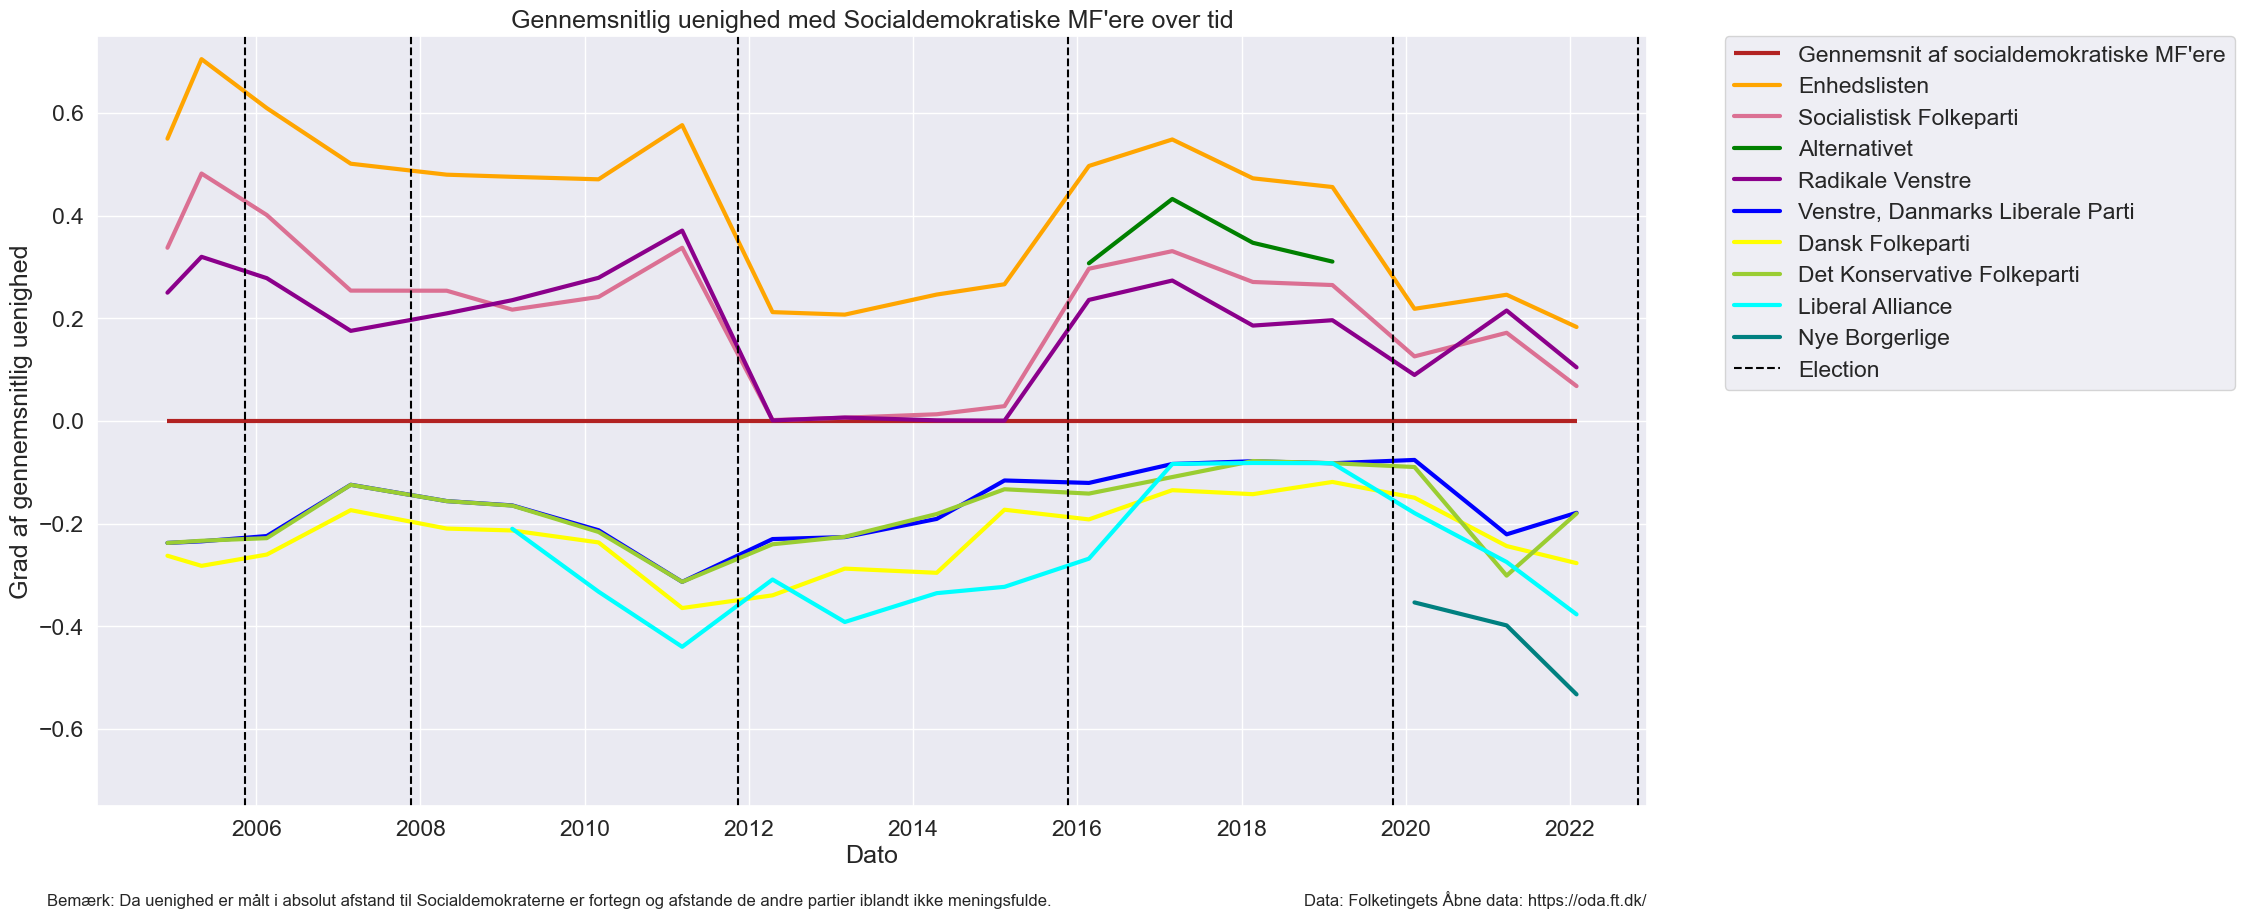

In [ ]:
#We plot all the parties
import seaborn as sns

#We plot the distance between the social democrats and the other parties
sns.set_style("darkgrid")

#set text size

#set font to arial
sns.set(font="Arial")
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,10))
middle_date = [periods_dict[period][1] for period in periods]
offset = 0.02
other_parties = [party for party in parties if party != 'Socialdemokratiet']
ax.hlines(0, xmin = first_date, xmax=last_date, color = 'firebrick', label = "Gennemsnit af socialdemokratiske MF'ere", linewidth = 3)
for party in other_parties:
    #We get the partition number for the party for each period if the distance is not None
    distance = [distance_all_periods[period][party] for period in periods if distance_all_periods[period][party] is not None]
    middle_date = [periods_dict[period][1] for period in periods if distance_all_periods[period][party] is not None]
    #start_date = [periods_dict[period][0] for period in periods if distance_all_periods[period][party] is not None] #an argument could be made for using start date
    ax.plot(middle_date, distance, label = party, color = color_map[party], linewidth = 3)


#We plot the elections
for election in elections:
    #if last election
    if election == elections[-1]:
        ax.axvline(election, color = 'black', linestyle = '--', label = 'Election')
    else:
        ax.axvline(election, color = 'black', linestyle = '--')
#ax.axvline(datetime.datetime(2008,8,28), color = 'black', linestyle = '-', label = 'Ny Alliance becomes Liberal Alliance')
#plot legend outside of plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Dato')
ax.set_ylabel("Grad af gennemsnitlig uenighed")
ax.set_title("Gennemsnitlig uenighed med Socialdemokratiske MF'ere over tid")
ax.set_ylim(-0.75,0.75)
#set figure footnote 
fig.text(0.9, 0.01, 'Data: Folketingets Åbne data: https://oda.ft.dk/', ha='right', fontsize = 12)
fig.text(0.1, 0.01, 'Bemærk: Da uenighed er målt i absolut afstand til Socialdemokraterne er fortegn og afstande de andre partier iblandt ikke meningsfulde.', ha='left', fontsize = 12)
plt.show()





# 7) TF-IDF

In this part, we will explore the law texts from the laws that were passed and see if we can find some interesting words that defines the different parties, periods and categories of laws.

Table of contents:

* [Load Pickle File](#load-pickle-file-with-laws)
* [Get majority vote for party](#get-majority-vote-for-party)
* [TF-IDF for Parties](#tf-idf-for-parties)
* [Periods](#periods)
* [Environment category over periods](#environment-over-periods)


## Load pickle file with laws <a class="anchor" id="load-pickle-file-with-laws"></a>

In [ ]:
# Load pickle file
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)

In [ ]:
df.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

## Get majority vote for party <a class="anchor" id="get-majority-vote-for-party"></a>

To be able to differentiate the parties by how they vote, we needed to define a common vote for each party. To do this, we look at all the passed laws and how the members of the party voted for each law. We defined the party vote as the vote that the majority of the party voted for on each law.

We create a new column in the dataframe containing the vote for the majority of the party. These votes have the types 1 (yes-vote), 2 (no-vote), 3 (neither yes or no).

In [ ]:
#First create a dict for each law that contains the majority vote for each party

#Function that returns the majority typeid for each party for a given law
def get_majority_typeid_for_party(law):
    #Create a dict with the party as key and the typeid as value
    party_typeid_dict = {}
    for vote in law:
        #If the party is not already in the dict, add it
        if vote['party'] not in party_typeid_dict:
            party_typeid_dict[vote['party']] = [vote['typeid']]
        #If the party is already in the dict, append the typeid to the list of typeids
        else:
            party_typeid_dict[vote['party']].append(vote['typeid'])
    #Create a dict with the party as key and the majority typeid as value
    party_majority_typeid_dict = {}
    for party in party_typeid_dict:
        #Get the most common typeid for each party
        party_majority_typeid_dict[party] = max(set(party_typeid_dict[party]), key=party_typeid_dict[party].count)
    return party_majority_typeid_dict

#create a new column in the votes_df_combined dataframe called majority_typeid_for_party
df['majority_party_vote'] = [get_majority_typeid_for_party(law) for law in df['votes_adjusted']]

## TF-IDF for parties <a class="anchor" id="tf-idf-for-parties"></a>

We want to investigate whether the passed laws could say something about the different parties and how they differentiate.

First, we create a dictionary with all of the text from the 'resume' of a law with the party that voted yes as a key.

In [ ]:
#Function that creates a dict with all the text in 'resume' summed for each unique key in the majority_party_vote column if the key has the value 1 in the majority_party_vote (yes)
def get_text_for_party_yes(law_text_list, majority_party_vote_list):
    #Create a dict with the party as key and the text as value
    party_text_dict = {}
    for law_text, party_vote_dict in zip(law_text_list, majority_party_vote_list):
        for party in party_vote_dict:
        #If the party is not already in the dict, add it
            if party_vote_dict[party] == 1:
                if party not in party_text_dict:
                    party_text_dict[party] = law_text
                else:
                    party_text_dict[party] += law_text
    return party_text_dict

text_dict = get_text_for_party_yes(list(df['resume']), list(df['majority_party_vote']))

Then we tokenize the text to be able to work with the text word for word

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
stopwords_dk = nltk.corpus.stopwords.words('danish')

#The word foreslås appear for parties as the most prominent word but says very little, this is added to stopwords
stopwords_dk.append('foreslås')

# Function to tokenize text
def tokenize_dict(party_text_dict):
    tokenized_party_dict = {}
    for party in party_text_dict:
        tokenized_party_dict[party] = word_tokenize(party_text_dict[party])
    return tokenized_party_dict

law_token_dict = tokenize_dict(text_dict)

Underneath, we implement functions for calculating TF-IDF to be reused through this notebook

In [ ]:
# Calculate the frequency distribution of the words in each party
#only process words, and consider all words as lower-case
def get_tf(tokenized_dict):
    freqDist_dict = {}
    for party in tokenized_dict.keys():
        freqDist_dict[party] = nltk.FreqDist(word.lower() for word in tokenized_dict[party] if word.isalpha() and word.lower() not in stopwords_dk)
    return freqDist_dict

law_tf = get_tf(law_token_dict)

def get_idf(freqDist_dict: dict):
    idf = {}

    #for each party
    for party in freqDist_dict.keys():
        #for each word in the law text of that party
        for word in freqDist_dict[party].keys():
            #if the word has not been IDF scored yet
            if word not in idf.keys():
                for freqDist in freqDist_dict.values():
                    if word in freqDist.keys():
                        #if the word is in the frequency dict of a given community, 1 to the IDF score
                        if word not in idf.keys():
                            idf[word] = 1
                        else:
                            idf[word] += 1
                #Divide the total number of communities ("documents ") with the number of communities in which the word appeared
                idf[word] = len(freqDist_dict.keys())/ idf[word]
                idf[word] = np.log2(idf[word])

    return idf

law_idf = get_idf(law_tf)

#normalize freqdist
def get_tf_norm(freqDist_dict: dict, token_dict: dict):
    tf = defaultdict()
    for party in freqDist_dict.keys():
        tf[party] = defaultdict()
        for word in freqDist_dict[party].keys():
            tf[party][word] = freqDist_dict[party][word]/len(token_dict[party])
    return tf

law_tf_norm = get_tf_norm(law_tf, law_token_dict)


# Calculate tf-idf
def get_tf_idf(tf_dict: dict, idf_dict: dict):
    tf_idf = defaultdict()
    for party in tf_dict.keys():
        tf_idf[party] = defaultdict()
        # For each word in the community, multiply the TF and IDF score
        for word in tf_dict[party].keys():
            tf_idf[party][word] = tf_dict[party][word] * idf_dict[word]
    return tf_idf

law_tf_idf = get_tf_idf(law_tf_norm, law_idf)

def law_text_to_tf_idf(text_dict):
    token_dict = tokenize_dict(text_dict)
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict

def token_to_tf_idf(token_dict):
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict


We then look at the top 5 words for each party according to TF. Here we can see that only analysing words from TF does not say anything unique about the party.

In [ ]:
# Get the top 5 words in each party before IDF sorting
for party in sorted(law_tf.keys()):
    print(f'{party} top 5 words: {law_tf[party].most_common(5)}')

Alternativet top 5 words: [('lovforslaget', 1586), ('kan', 603), ('kraft', 536), ('folkeparti', 514), ('ved', 458)]
Dansk Folkeparti top 5 words: [('loven', 3273), ('lovforslaget', 3138), ('kan', 1917), ('folkeparti', 1550), ('ved', 1522)]
Det Konservative Folkeparti top 5 words: [('loven', 3487), ('lovforslaget', 3324), ('kan', 2043), ('ved', 1608), ('folkeparti', 1577)]
Enhedslisten top 5 words: [('loven', 2203), ('lovforslaget', 2062), ('kan', 1365), ('ved', 1081), ('kraft', 876)]
Fólkaflokkurin top 5 words: [('danske', 8), ('færøernes', 7), ('landsstyre', 7), ('kan', 7), ('færøske', 7)]
Inuit Ataqatigiit top 5 words: [('lovforslaget', 42), ('grønland', 30), ('kan', 19), ('grønlands', 18), ('loven', 18)]
Kristendemokraterne top 5 words: [('lovforslaget', 98), ('baggrund', 74), ('kan', 54), ('loven', 48), ('ved', 40)]
Liberal Alliance top 5 words: [('lovforslaget', 2576), ('loven', 2144), ('kan', 1459), ('folkeparti', 1209), ('ved', 1092)]
Ny Alliance top 5 words: [('loven', 139), ('

We then look at the top 10 words for each party according to TF-IDF, which says a little more about each party. However, there are still a lot of words that does not say much about how the parties differentiate from eachother.

In [ ]:
# List the top 5 words in each party according to TF-IDF
for party in sorted(law_tf_idf.keys()):
    #round the [1] element of the tuple (the TF-IDF score) to 3 decimals
    print(f'{party} top 5 words: {[(word, round(score, 3)) for word, score in sorted(law_tf_idf[party].items(), key=lambda x: x[1], reverse=True)[:5]]}')


Alternativet top 5 words: [('folkeparti', 0.001), ('venstre', 0.001), ('liberal', 0.001), ('alliance', 0.001), ('dansk', 0.001)]
Dansk Folkeparti top 5 words: [('folkeparti', 0.001), ('dansk', 0.001), ('loven', 0.001), ('venstre', 0.001), ('del', 0.001)]
Det Konservative Folkeparti top 5 words: [('folkeparti', 0.001), ('loven', 0.001), ('venstre', 0.001), ('dansk', 0.001), ('del', 0.001)]
Enhedslisten top 5 words: [('folkeparti', 0.001), ('loven', 0.001), ('venstre', 0.001), ('dansk', 0.0), ('regler', 0.0)]
Fólkaflokkurin top 5 words: [('færøernes', 0.006), ('landsstyre', 0.006), ('sagsområder', 0.006), ('vágar', 0.005), ('ligeværdige', 0.005)]
Inuit Ataqatigiit top 5 words: [('selvstyret', 0.002), ('grønland', 0.002), ('videoafhøring', 0.001), ('arbejdsskadestyrelsens', 0.001), ('anstalt', 0.001)]
Kristendemokraterne top 5 words: [('fremgik', 0.001), ('bemærkningerne', 0.001), ('momsfrit', 0.001), ('kulturinstitutioner', 0.001), ('dansk', 0.001)]
Liberal Alliance top 5 words: [('folke

To visualize the words from the TF-IDF analysis above, we create word clouds

In [ ]:
# Create a word cloud for each community
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function for creating wordclouds of party votes
def create_wordclouds(tf_idf_dict, dim):
    fig, axs = plt.subplots(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    for n, party in enumerate(tf_idf_dict.keys()):
        wordcloud = WordCloud(
                    max_font_size=50, 
                    max_words=50,
                    stopwords = stopwords_dk,
                    background_color="white",
                    collocations=False,
                    ).generate_from_frequencies(tf_idf_dict[party])
        
        # Create a subplot of the wordcloud
        ax = plt.subplot(dim[0], dim[1], n+1)
        
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(party, fontsize=30)

    fig.tight_layout()
    plt.show()

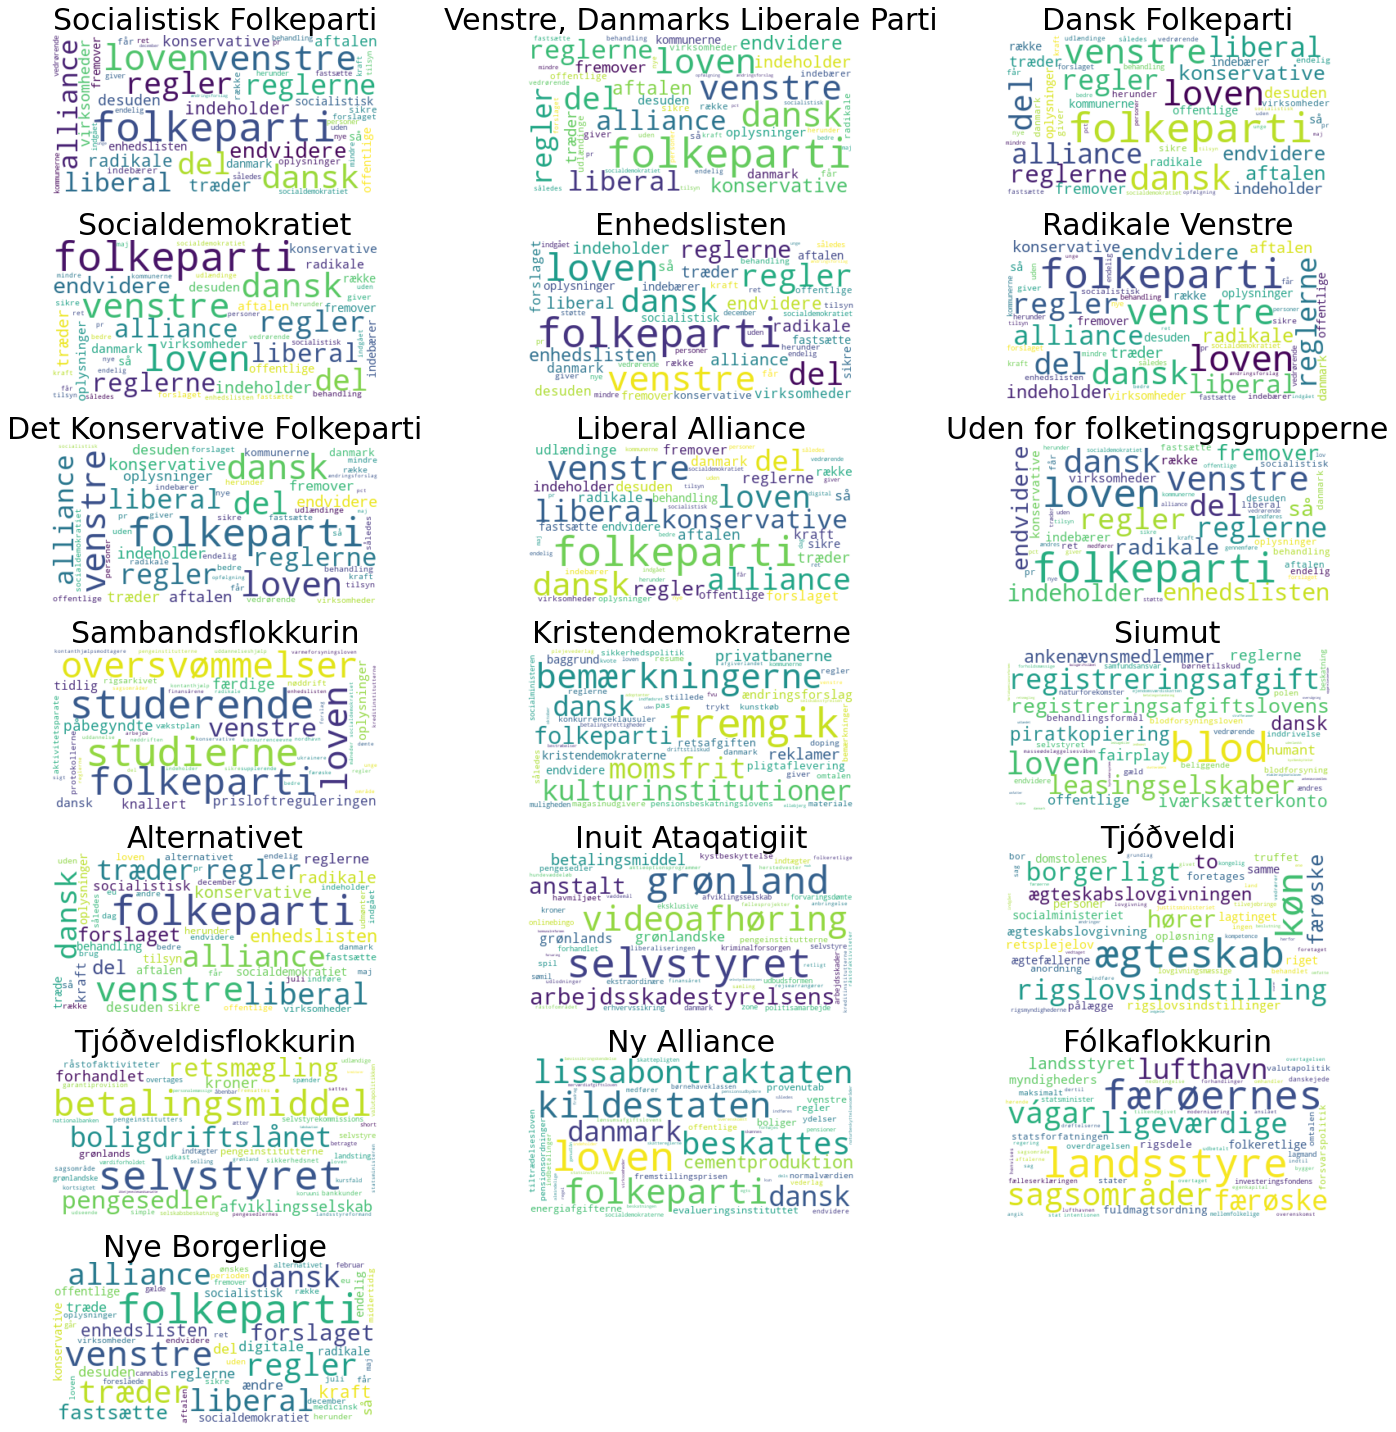

In [ ]:
create_wordclouds(law_tf_idf, (7,3))

### Remove all smaller partiers to avoid a scewed TD-IDF score 

Some parties have only been part of the pariliament work for a reduced period of time, so this creates some scewed TF-IDF scores, so the words does not say much about how the parties differentiate

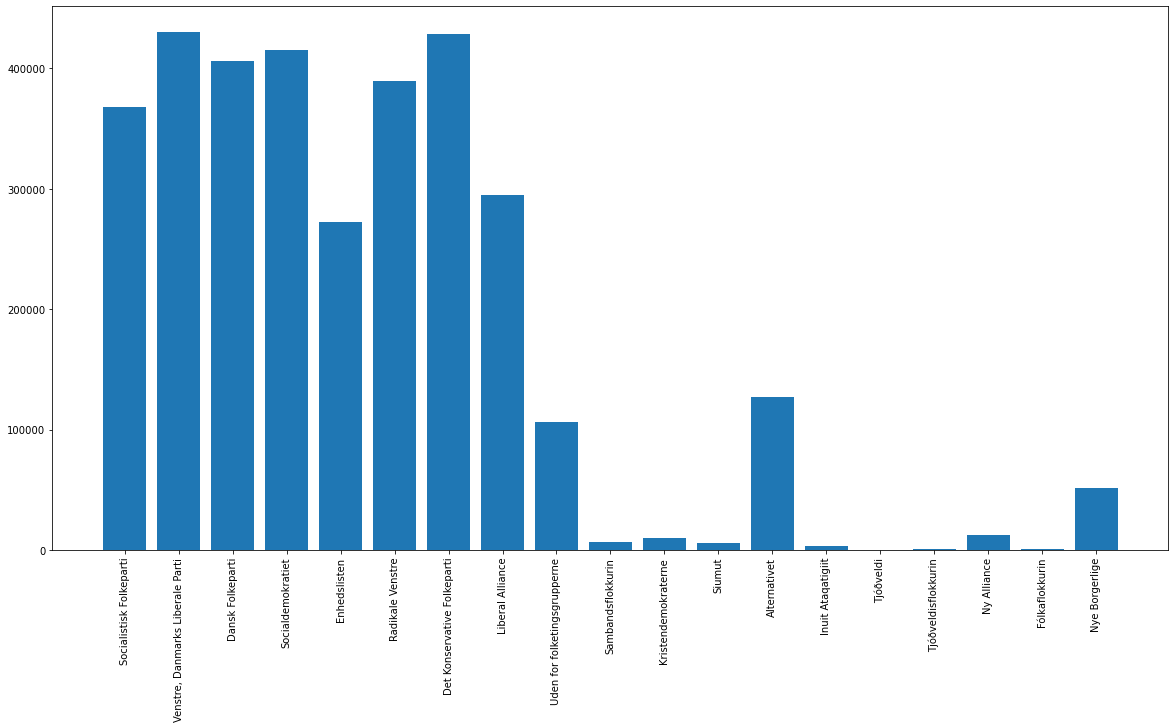

In [ ]:
#plot the number of words in each party
plt.figure(figsize=(20, 10))
plt.bar(law_token_dict.keys(), [len(law_token_dict[party]) for party in law_token_dict.keys()])
plt.xticks(rotation=90)
plt.show()

In [ ]:
subset_law_token = law_token_dict.copy()
small_parties =  ['Inuit Ataqatigiit', 'Tjóðveldi', 'Fólkaflokkurin', 'Tjóðveldisflokkurin', 'Uden for folketingsgrupperne', 'Sambandsflokkurin', 'Siumut', 'Ny Alliance', 'Kristendemokraterne', 'Nye Borgerlige']

#Remove list of small parties from the subset_law_token dict
for party in small_parties:
    if party in subset_law_token.keys():
        del subset_law_token[party]

In [ ]:
# Create tf-idf for the subset of parties
subset_tf_idf = token_to_tf_idf(subset_law_token)

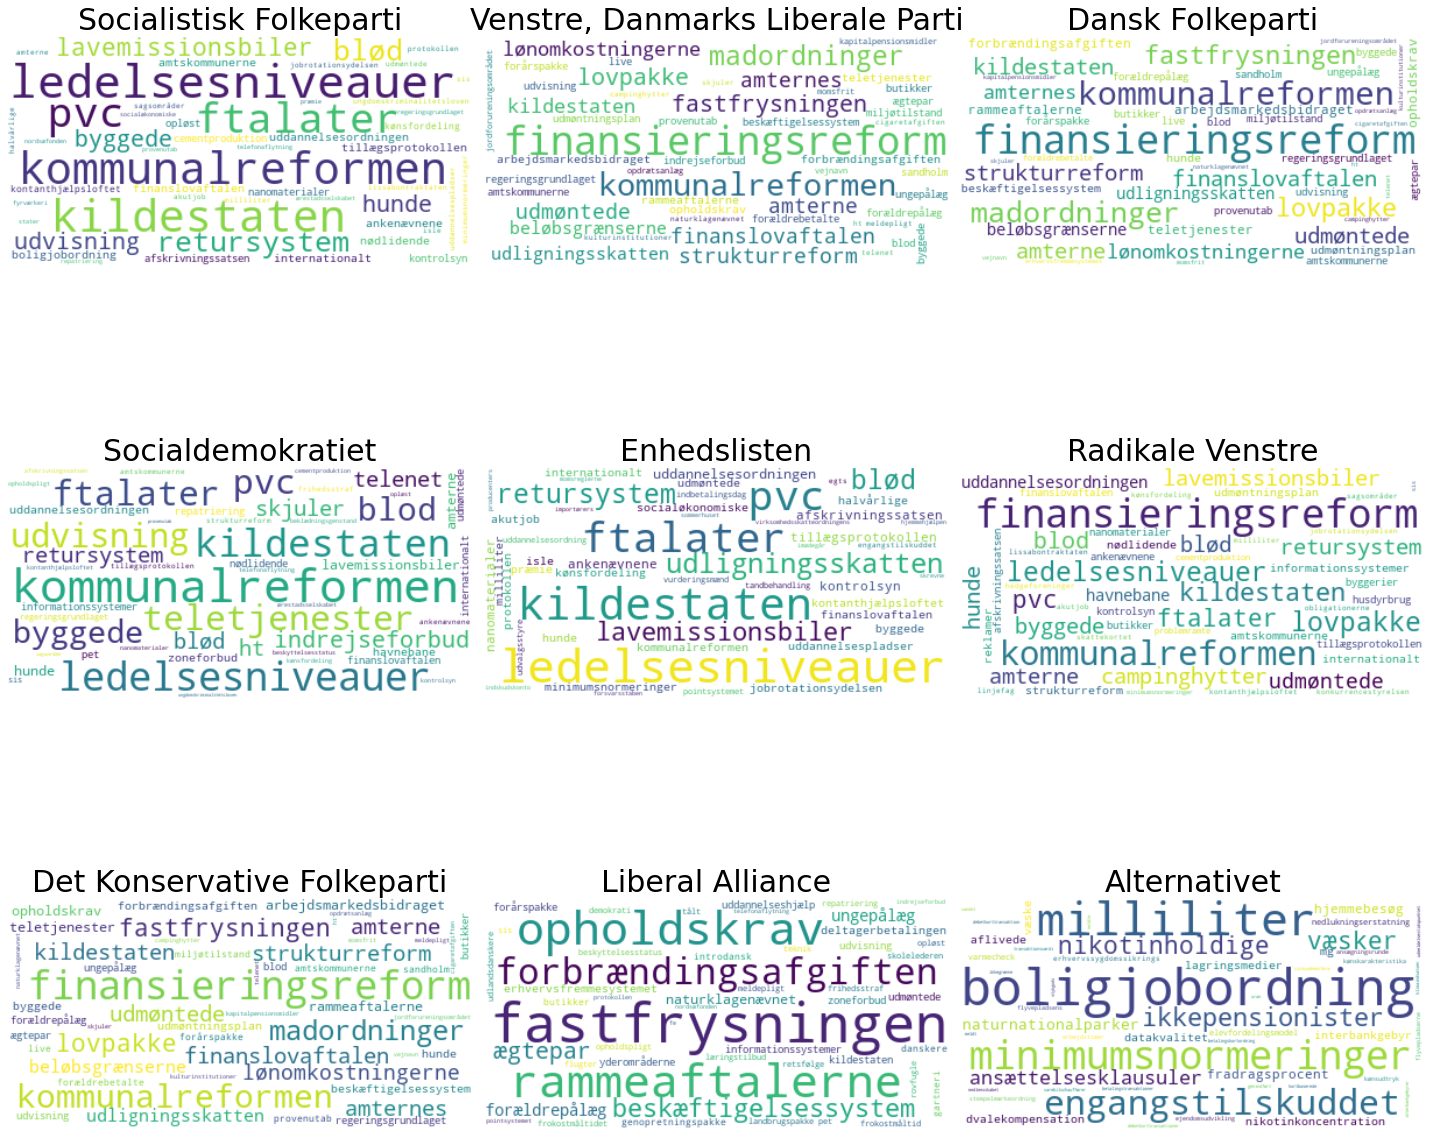

In [ ]:
# Create a word cloud for each community
create_wordclouds(subset_tf_idf, (3,3))	

For the purpose of showing a word cloud in the report, we create a word cloud of enhedslisten in the shape of denmark.

In [ ]:
def create_wordcloud(tf_idf_dict, title, colormap):
    wordcloud = WordCloud(
                scale=5,
                mask=np.array(Image.open('denmark_map.png')),
                max_font_size=50, 
                max_words=100,
                stopwords = stopwords_dk,
                colormap=colormap,
                background_color="white",
                collocations=False,
                ).generate_from_frequencies(tf_idf_dict)
    
    # Display the generated image
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

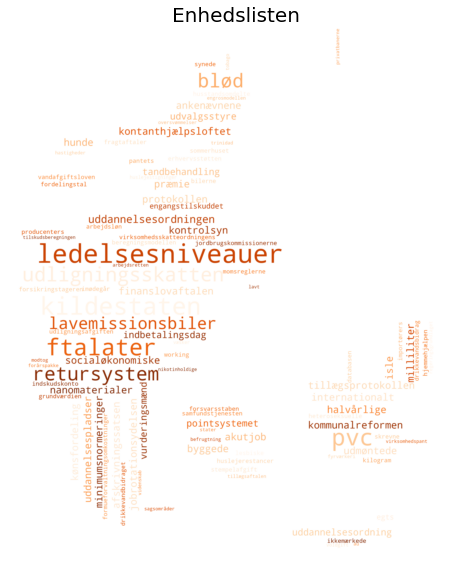

In [ ]:
party = 'Enhedslisten'
create_wordcloud(subset_tf_idf[party], party, 'Oranges')

## Periods <a class="anchor" id="periods"></a>

We want to investigate what represents each parliament period through TF-IDF on the resume texts of the passed laws. First, we create a dictionary with all of the resume text and period id as key.

In [ ]:
#Function that creates a dict with all the text in 'resume' summed for each unique key in the periode_id column
def get_text_for_period(law_text_list, period_id_list):
    #Create a dict with the period as key and the text as value
    period_text_dict = {}
    for law_text, period_id in zip(law_text_list, period_id_list):
        #If the period is not already in the dict, add it
        if period_id not in period_text_dict.keys():
            period_text_dict[period_id] = law_text
        else:
            period_text_dict[period_id] += law_text
    return period_text_dict

text_dict_period = get_text_for_period(list(df['resume']), list(df['periode_id']))
text_dict_period.keys()

dict_keys([32, 31, 30, 28, 35, 27, 138, 139, 144, 146, 26, 24, 25, 23, 22, 21, 20, 148, 150, 151, 153, 155])

Then we check if any of the periods are significantly shorter than others, to make sure not to scew the IDF score.

In [ ]:
#print len of text in each period
for period in text_dict_period.keys():
    print(f'Period {period} has {len(text_dict_period[period])} characters')

Period 32 has 154126 characters
Period 31 has 178511 characters
Period 30 has 123461 characters
Period 28 has 152485 characters
Period 35 has 153005 characters
Period 27 has 167305 characters
Period 138 has 8784 characters
Period 139 has 157782 characters
Period 144 has 188503 characters
Period 146 has 214421 characters
Period 26 has 136858 characters
Period 24 has 994 characters
Period 25 has 128445 characters
Period 23 has 125831 characters
Period 22 has 148689 characters
Period 21 has 129437 characters
Period 20 has 65066 characters
Period 148 has 196245 characters
Period 150 has 649 characters
Period 151 has 126786 characters
Period 153 has 233030 characters
Period 155 has 192500 characters


Based on the results above, we will sort off Period 138, 24 and 150 as these are significantly shorter than the other periods.

In [ ]:
# Sort off Period 138, 24 and 150
delete_periods = [138, 24, 150]

def sort_off_period(period_dict, periods_to_sort_off):
    for period in periods_to_sort_off:
        if period in period_dict.keys():
            del period_dict[period]

sort_off_period(text_dict_period, delete_periods)

We then calculate TF-IDF on the law texts from the remaining periods

In [ ]:
tf_idf_period = law_text_to_tf_idf(text_dict_period)

To make the plots of the periods more understandable than just using the period id, (which doesn't explain much about the period) we create titles for the periods including the year(s) of the period.

In [ ]:
# To make periods more understandable, extract and add the year to the title
def extract_year_from_periods(period_list):
    #extract the first 4 letters of the dato_sagstrin column (the year) and create a new column with this
    df['year'] = df['dato_sagstrin'].apply(lambda x: x[:4])

    #for each period in text_dict_period.keys() find the lowest and highest year in the df and create a dict with the period as key and the lowest and highest year as value
    period_year_dict = {}
    for period in period_list.keys():
        #find the lowest year in the df for each period
        lowest_year = df.loc[df['periode_id'] == period]['year'].min()
        #find the highest year in the df for each period
        highest_year = df.loc[df['periode_id'] == period]['year'].max()
        #add the lowest and highest year to the period_year_dict
        period_year_dict[period] = [lowest_year, highest_year]
    
    return period_year_dict

period_titles = extract_year_from_periods(text_dict_period)

Lastly, we plot the word clouds of the periods.

In [ ]:
# Function to create word clouds for each period
def create_wordclouds(tf_idf_dict, dim, sub_plot_name, titles):

    fig, axs = plt.subplots(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    #fig.suptitle("Wordclouds of the parties", fontsize=16)

    for n, key in enumerate(tf_idf_dict.keys()):
        wordcloud = WordCloud(
                    max_font_size=50, 
                    max_words=30,
                    background_color ='white',
                    stopwords = stopwords_dk,
                    collocations=False,
                    ).generate_from_frequencies(tf_idf_dict[key])
        
        # Create a subplot of the wordcloud
        ax = plt.subplot(dim[0], dim[1], n+1)
        
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title(f'{sub_plot_name} {key} {titles[key][0]}-{titles[key][1]}', fontsize=20)

    fig.tight_layout()
    plt.show()

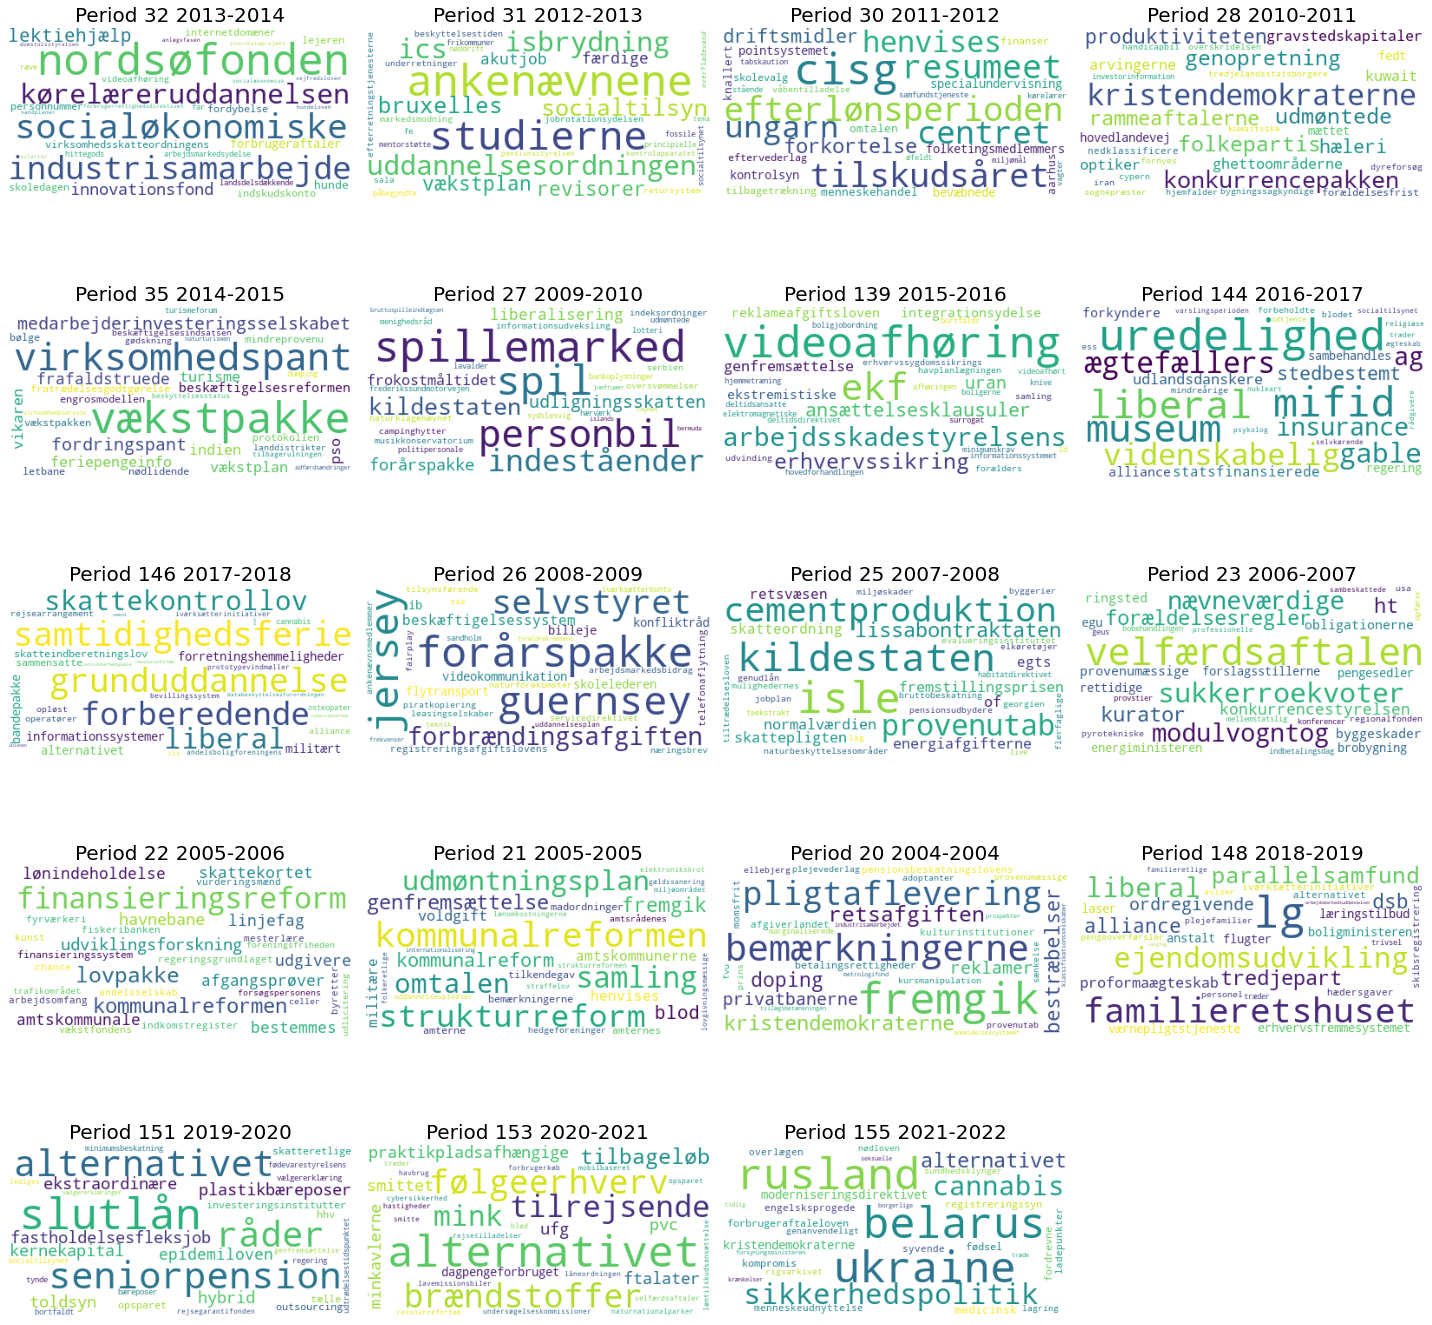

In [ ]:
create_wordclouds(tf_idf_period, (5,4), 'Period', period_titles)

We plot only some of the periods of significance to show in the report

In [ ]:
def create_wordcloud(tf_idf_dict, title):
    wordcloud = WordCloud(
                scale=5,
                mask=np.array(Image.open('denmark_map.png')),
                max_font_size=50, 
                max_words=100,
                stopwords = stopwords_dk,
                background_color="white",
                collocations=False,
                ).generate_from_frequencies(tf_idf_dict)
    
    # Display the generated image
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

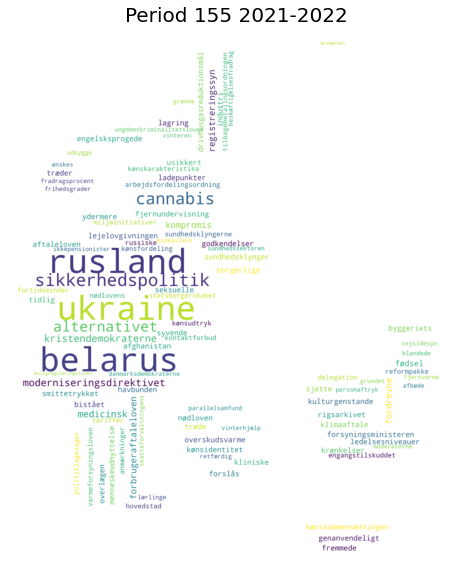

In [ ]:
create_wordcloud(tf_idf_period[155], 'Period 155 2021-2022')